# <div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Mini Project 2 - Estimation of obesity levels based on eating habits and physical condition

### The question will be: how well can the 'obesity class' be predicted from the survey data and the other metrics given?  Ideally, medical professionals would wish to be able to predict the likelihood of someone becoming obese in the *future*, based on behavioural features.

In [91]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import RFE

from textwrap import wrap

%matplotlib inline

In [69]:
# Read data
obesity = pd.read_csv('/Users/gaylecferguson/Data/obesity.csv', header = 0)
obesity.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

In [4]:
# 2111 observations, 17 features
obesity.shape

(2111, 17)

In [5]:
obesity.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [6]:
# No null values in the dataset
obesity.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [7]:
# Checking how even the catagories are for the binary data
# Family history with overweight
obesity['family_history_with_overweight'].value_counts()

yes    1726
no      385
Name: family_history_with_overweight, dtype: int64

In [8]:
# There are very few smokers. If we wanted to test the effect of smoking, would need to generate more synthetic data
obesity['SMOKE'].value_counts()

no     2067
yes      44
Name: SMOKE, dtype: int64

In [9]:
# Calorie consumption monitoring (SCC). Again, little data in the 'yes' category.  
# Most of the subjects do not monitor their calorie intake
obesity['SCC'].value_counts()

no     2015
yes      96
Name: SCC, dtype: int64

In [10]:
# Consumption of food between meals - most are 'sometimes' or 'frequently'
# Would need to synthetically generate more 'always' and 'no' to see the true impact of this variable.
obesity['CAEC'].value_counts()

Sometimes     1765
Frequently     242
Always          53
no              51
Name: CAEC, dtype: int64

In [11]:
# Frequent consumption of alcohol
# Would need to synthetically generate more 'frequently' and 'always' to see the true impact of this variable.
obesity['CALC'].value_counts()

Sometimes     1401
no             639
Frequently      70
Always           1
Name: CALC, dtype: int64

In [12]:
# Frequent consumption of high caloric food
# People always lie on surveys!
obesity['FAVC'].value_counts()

yes    1866
no      245
Name: FAVC, dtype: int64

In [26]:
# Frequent consumption of vegetables
# I'm not sure why this question generated float data, unless people selected multiple options and it was averaged
obesity['FCVC'].value_counts()

3.000000    652
2.000000    600
1.000000     33
2.823179      2
2.214980      2
           ... 
2.927409      1
2.706134      1
2.010684      1
2.300408      1
2.680375      1
Name: FCVC, Length: 810, dtype: int64

In [13]:
# Number of main meals
# Same comment as above
obesity['NCP'].value_counts()

3.000000    1203
1.000000     199
4.000000      69
2.776840       2
3.985442       2
            ... 
3.054899       1
3.118013       1
3.335876       1
3.205009       1
1.089048       1
Name: NCP, Length: 635, dtype: int64

### Age distribution of surveyed population

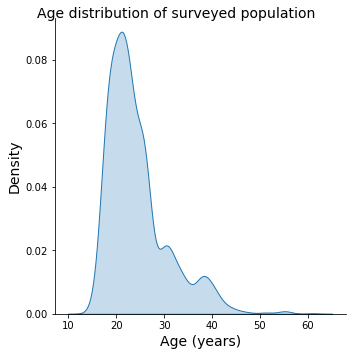

In [14]:
# The population had a very narrow range of ages: most between 18 and 30.

palette = sns.color_palette(palette="light:#5A9", as_cmap=True)
p = sns.displot(data=obesity, x="Age", kind='kde', palette=palette, fill=True)
p.fig.suptitle("Age distribution of surveyed population",fontsize=14)
p.ax.set_xlabel("Age (years)",fontsize=14)
p.ax.set_ylabel("Density",fontsize=14)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
#p.fig.savefig("Age_distribution.jpg")
plt.show()

### Looking at obesity classifications 

In [15]:
# Value counts for each class
# Even spread of data across the 7 classes
obesity['NObeyesdad'].value_counts()

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: NObeyesdad, dtype: int64

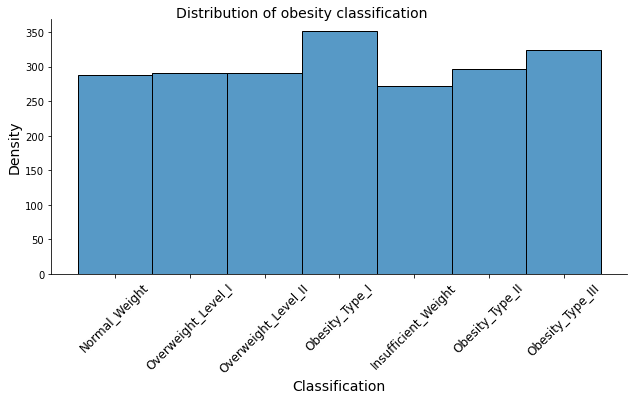

In [16]:
# Looking at obesity classifications
# Even spread of data across the 7 classes

sns.set_color_codes(palette="pastel")
p = sns.displot(x='NObeyesdad', data=obesity, kind='hist', fill=True, height=5, aspect=1)
p.ax.set_xlabel("Classification",fontsize=14)
p.ax.set_ylabel("Density",fontsize=14)
plt.xticks(rotation=45, horizontalalignment='center', fontsize=12)
#plt.ylim((10,16)) # adjust as needed
p.fig.suptitle("Distribution of obesity classification",fontsize=14)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
p.fig.set_size_inches(10, 6)

#p.fig.savefig("Obesity_classification_distribution.jpg")
plt.show()

### Feature Creation - BMI

BMI is the usual metric for determining 'obesity class'. 

BMI = Weight (in kg) / height (in m) squared.

As 'obesity class' is often determined by BMI alone, this will likely be the major predictive feature.  However, it is noted that pfredicting obesity from BMI is therefore trivial and the resultant model would not be of much use, as we want to predict *future* likelihood of obesity, not those already obese.  I included this feature for the first round of modelling nevertheless. 

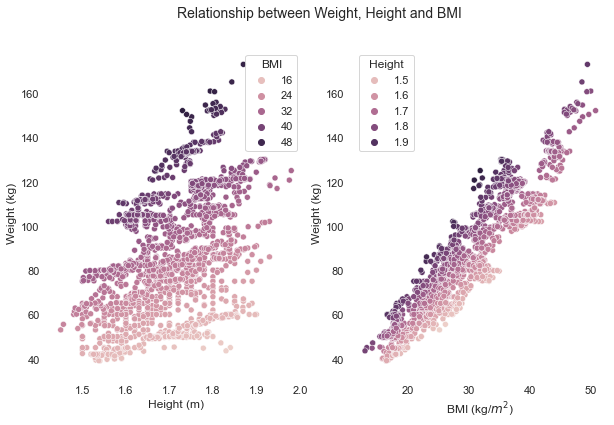

In [70]:
# Calculated BMI from weight and height
# BMI = weight (kg) / height (m^2)
# Plotting shows the expected relationship between weight, height and BMI

obesity['BMI'] = obesity['Weight'] / obesity['Height'] ** 2

sns.set_theme(style="white")
fig, ax =plt.subplots(1,2,figsize=(10, 6))

sns.scatterplot(x='Height', y='Weight', data=obesity, hue='BMI', ax=ax[0])
sns.scatterplot(x='BMI', y='Weight', data=obesity, hue='Height', ax=ax[1])
ax[0].set(xlabel="Height (m)", ylabel="Weight (kg)")
ax[1].set(xlabel="BMI (kg/$m^2$)", ylabel="Weight (kg)")

sns.despine(left=True,bottom=True)
fig.suptitle("Relationship between Weight, Height and BMI", fontsize=14)
#fig.savefig("Weight_Height_BMI.jpg")
plt.show()

### Obesity by gender 

In [18]:
# Gender - data is evenly spread across males and females
obesity['Gender'].value_counts()

Male      1068
Female    1043
Name: Gender, dtype: int64

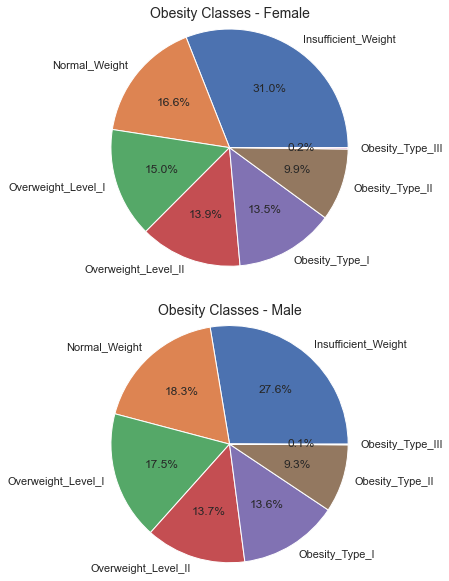

In [71]:
# Obesity by gender
# The 'class' breakdowns are the same for male and female - it's likely that the synthetic data was designed 
    # to generate equal numbers of males and females for each class (and equal number of observations for each class)

labels=('Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 
        'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III')
female = obesity[(obesity.Gender == 'Female')].NObeyesdad.value_counts()
male = obesity[(obesity.Gender == 'Male')].NObeyesdad.value_counts()

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))

ax1.pie(female, labels=labels, radius = 1.2,autopct = '%1.1f%%')
ax2.pie(male, labels=labels, radius = 1.2,autopct = '%1.1f%%')
ax1.set_title('Obesity Classes - Female', fontsize=14)
ax2.set_title('Obesity Classes - Male', fontsize=14)

#fig.savefig("Obesity_gender.jpg")
plt.show()

One oddity of the above graph is that both male and female pies show only 0.1% of the population in 'Obesity_Type_III' class. However, an earlier graph shows that 'Obesity_Type_III' has just as many observations overall as the other six classes, so I'm not sure why this discrepancy has occured. 

In [72]:
# All but one of the individuals in 'Obesity_Type_III' category are female.  
# I can't see any obvious reason why the female pie graph above is not counting these.

obtype3 = obesity.loc[obesity['NObeyesdad'] == 'Obesity_Type_III']
print(obtype3.shape)
print(obtype3.value_counts('Gender'))
obtype3.head()

(324, 18)
Gender
Female    323
Male        1
dtype: int64


Gender        Age    Height      Weight family_history_with_overweight  \
202  Female  26.000000  1.560000  102.000000                            yes   
344    Male  18.000000  1.870000  173.000000                            yes   
403  Female  26.000000  1.660000  112.000000                            yes   
498  Female  25.196214  1.686306  104.572712                            yes   
499  Female  18.503343  1.683124  126.673780                            yes   

    FAVC  FCVC  NCP        CAEC SMOKE      CH2O SCC       FAF  TUE       CALC  \
202  yes   3.0  3.0   Sometimes   yes  1.000000  no  0.000000  1.0  Sometimes   
344  yes   3.0  3.0  Frequently    no  2.000000  no  2.000000  1.0  Sometimes   
403   no   3.0  3.0   Sometimes    no  3.000000  no  0.000000  0.0         no   
498  yes   3.0  3.0   Sometimes    no  1.152736  no  0.319156  1.0  Sometimes   
499  yes   3.0  3.0   Sometimes    no  1.115967  no  1.541072  1.0  Sometimes   

                    MTRANS        NObeyesdad        BMI  
202  Public_Transportation  Obesity_Type_III  41.913215  
344  Public_Transportation  Obesity_Type_III  49.472390  
403             Automobile  Obesity_Type_III  40.644506  
498  Public_Transportation  Obesity_Type_III  36.774400  
499  Public_Transportation  Obesity_Type_III  44.715131

Text(0.5, 1.0, 'Obesity classification by BMI, gender distributions')

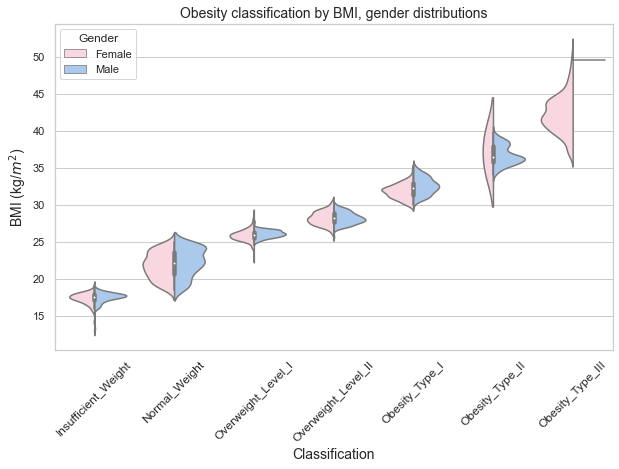

In [73]:
# Obesity by gender - we see differences in the distribution shapes and sizes only in the two most obese classes
# In this graph we *DO* see the 'Obesity_Type_III' females
# First attempt resulted in a plot with one category ("insufficient weight") out of sequence
   # So first need to get the categories in order
    # This successfully converted 'NObeyesdad' from 'object' to 'category', with the categories in sequence

from pandas.api.types import CategoricalDtype
cat_obesity = CategoricalDtype(['Insufficient_Weight','Normal_Weight','Overweight_Level_I',
                                'Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III'])
obesity['NObeyesdad'] = obesity['NObeyesdad'].astype(cat_obesity)

sns.set_theme(style="whitegrid")
sns.set_color_codes(palette='pastel')
fig, ax = plt.subplots(figsize=(10,6))
p = sns.violinplot(x="NObeyesdad", y="BMI", hue="Gender",
                    data=obesity, palette=['xkcd:light pink', 'b'], split=True)
p.set_xlabel("Classification",fontsize=14)
p.set_ylabel("BMI (kg/$m^2$)",fontsize=14)
plt.xticks(rotation=45, horizontalalignment='center', fontsize=12)
p.set_title("Obesity classification by BMI, gender distributions",fontsize=14)
#fig.savefig("Obesity_gender_2.jpg")

### Relationship between weight and obesity classification 

Although weight correlates well with obesity, there is significant overlap between the weight distributions for each 'obesity class', which is likely due to differences between how male and female weights map to obesity class.  

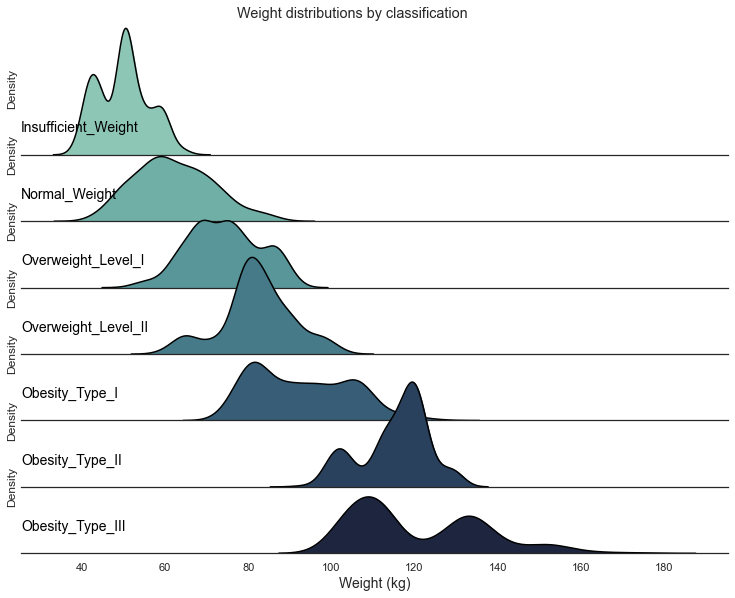

In [37]:
# Ridge plot - weight distributions per 'obesity level'

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # This makes the background transparent
palette = sns.cubehelix_palette(7, rot=-.35, light=.7)

g = sns.FacetGrid(obesity, palette=palette, row="NObeyesdad", hue="NObeyesdad", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="Weight", fill=True, alpha=1) # This paints/fills the inside area of the lines
g.map_dataframe(sns.kdeplot, x="Weight", color='black') # Draws another density plot to outline the first, 
                                                               # to differentiate them

# Create the plot labels    
def label(x, color, label):              
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=14,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "NObeyesdad")
    
g.fig.subplots_adjust(hspace=-.5)    # Controls the height space between the plots.
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)  # spines offset from the axes (a.k.a. "dropped spines")
g.set_axis_labels("Weight (kg)",fontsize=14)

plt.suptitle('Weight distributions by classification', y=0.98)
#g.fig.savefig("Weight distributions by classification.jpg")
plt.show()

### Relationship between age and obesity

There is no striking relationship between age and obesity beyond the 'insufficient weight' end of the scale, but this is likely because the majority of observations fall within a very narrow age range. 

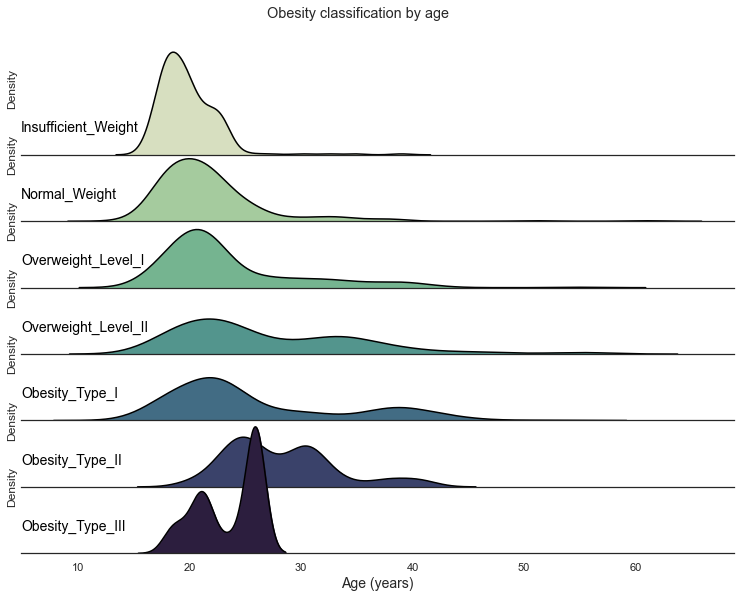

In [51]:
# Ridge plot - obesity classification by 'Age'
# Age dtype = float

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # This makes the background transparent
palette=sns.cubehelix_palette(n_colors=7, start=.5, rot=-.75)

g = sns.FacetGrid(obesity, palette=palette, row="NObeyesdad", hue="NObeyesdad", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="Age", fill=True, alpha=1) # This paints/fills the inside area of the lines
g.map_dataframe(sns.kdeplot, x="Age", color='black') # Draws another density plot to outline the first, 
                                                               # to differentiate them

# Create the plot labels    
def label(x, color, label):              
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=14,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "NObeyesdad")
    
g.fig.subplots_adjust(hspace=-.5)    # Controls the height space between the plots.
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)  # spines offset from the axes (a.k.a. "dropped spines")
g.set_axis_labels("Age (years)",fontsize=14)

plt.suptitle('Obesity classification by age', y=0.98)
#g.fig.savefig("Obesity classification by age.jpg")
plt.show()

### Relationship between weight and mode of transport

Most of the observations travel by public transport, and the weight distributions for this group are broad.
As expected, individuals who travel by walking or cycling tend to be distributed at the lower end of the weight scale and those who travel by car at the higher end of the weight scale.
It is not immediately obvious why motorcyclists should show the same pattern as walkers and bikers, but there are only 11 people in this group and the walkign group is also quite small.  There are only 7 cyclists. 

In [39]:
# Method of transport
obesity['MTRANS'].value_counts()

Public_Transportation    1580
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: MTRANS, dtype: int64

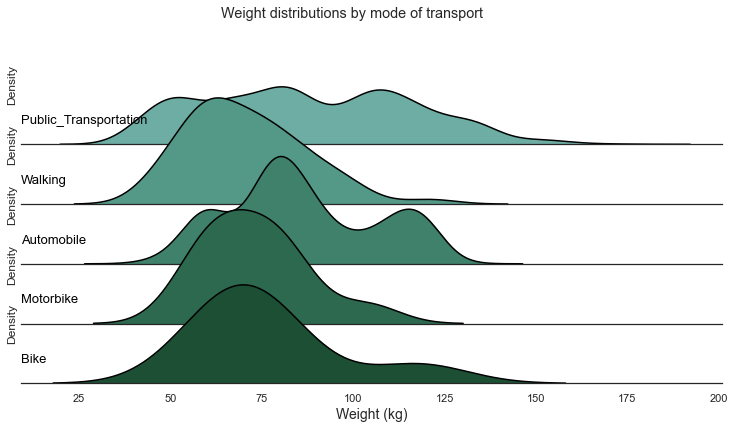

In [40]:
# Ridge plot - weight distributions per mode of transport

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # This makes the background transparent
#palette = sns.color_palette("Set2", 12)
palette = sns.color_palette("ch:2,r=.2,l=.6")
 # https://seaborn.pydata.org/generated/seaborn.cubehelix_palette.html

g = sns.FacetGrid(obesity, palette=palette, row="MTRANS", hue="MTRANS", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="Weight", fill=True, alpha=1) # This paints/fills the inside area of the lines
g.map_dataframe(sns.kdeplot, x="Weight", color='black') # Draws another density plot to outline the first, 
                                                               # to differentiate them

# Create the plot labels    
def label(x, color, label):              
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "MTRANS")
    
g.fig.subplots_adjust(hspace=-.5)    # Controls the height space between the plots.
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)  # spines offset from the axes (a.k.a. "dropped spines")
g.set_axis_labels("Weight (kg)",fontsize=14)

plt.suptitle('Weight distributions by mode of transport', y=0.98)
#g.fig.savefig("Weight distributions by mode of transport.jpg")
plt.show()

### Relationship between obesity and frequency of physical activity

The two highest obesity classes show lower physical activity than the other classes.  However, it is not possible to tell which is 'cause' and which is 'effect'.

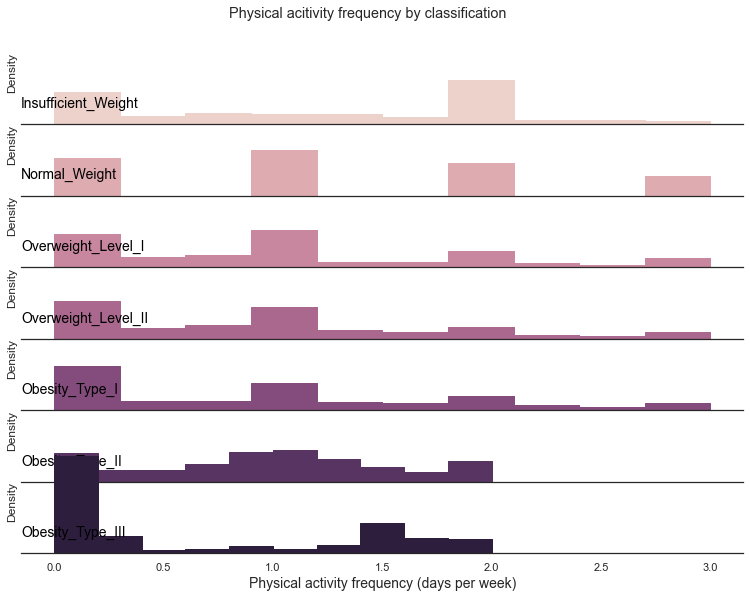

In [51]:
# Ridge plot - obesity classification by 'FAF' - physical activity frequency (dtype = float)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # This makes the background transparent
palette = sns.cubehelix_palette(7)

g = sns.FacetGrid(obesity, palette=palette, row="NObeyesdad", hue="NObeyesdad", aspect=9, height=1.2)
g.map_dataframe(sns.histplot, x="FAF", element="step", stat="density", fill=True, alpha=1) # This paints/fills the inside area of the lines
#g.map_dataframe(sns.histplot, x="FAF", color='black') # Draws another density plot to outline the first, 
                                                               # to differentiate them

# Create the plot labels    
def label(x, color, label):              
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=14,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "NObeyesdad")
    
g.fig.subplots_adjust(hspace=-0.3)    # Controls the height space between the plots.
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)  # spines offset from the axes (a.k.a. "dropped spines")
g.set_axis_labels("Physical activity frequency (days per week)",fontsize=14)

plt.suptitle('Physical acitivity frequency by classification', y=0.98)
#g.fig.savefig("Physical acitivity frequency by classification.jpg")
plt.show()

### Relationship between obesity and time spent using technology devices

There is no striking relationship between obesity class and time spent using technology devices; counterintuitively, the most obese individuals report spending less time on devices. However, it seems that the majority of this sampled population are not heavy device users. 

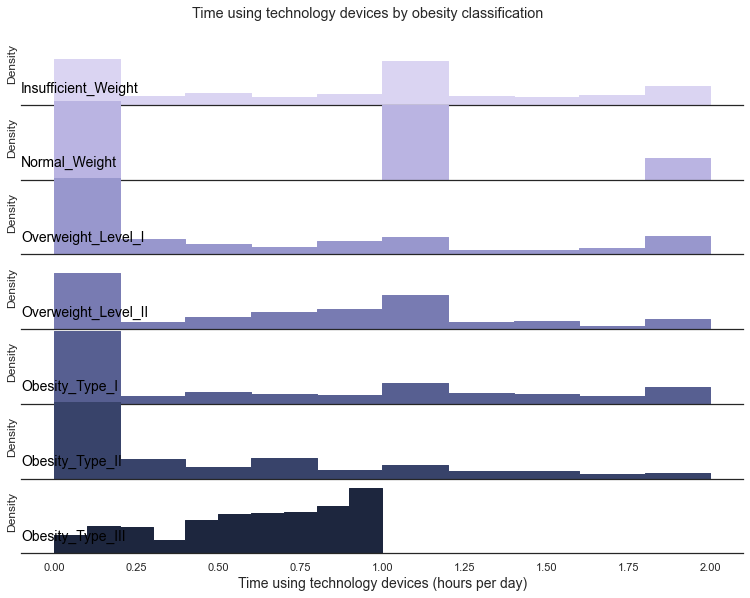

In [50]:
# Ridge plot - time using technology devices (TUE) by obesity classification (
# TUE dtype = float

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # This makes the background transparent
palette = sns.cubehelix_palette(7, start=2.8, rot=.1)

g = sns.FacetGrid(obesity, palette=palette, row="NObeyesdad", hue="NObeyesdad", aspect=9, height=1.2)
g.map_dataframe(sns.histplot, x="TUE", element="step", stat="density", fill=True, alpha=1) # This paints/fills the inside area of the lines
#g.map_dataframe(sns.kdeplot, x="TUE", color='black') # Draws another density plot to outline the first, 
                                                               # to differentiate them

# Create the plot labels    
def label(x, color, label):              
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=14,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "NObeyesdad")
    
g.fig.subplots_adjust(hspace=-.1)    # Controls the height space between the plots.
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)  # spines offset from the axes (a.k.a. "dropped spines")
g.set_axis_labels("Time using technology devices (hours per day)",fontsize=14)

plt.suptitle('Time using technology devices by obesity classification', y=0.98)
#g.fig.savefig("Time using technology devices by obesity classification.jpg")
plt.show()

### Relationship between obesity and water consumption

Water is needed for weight loss.  Interestingly, the most obese classes report drinking more water per day.  However, larger people need to drink more water to say hydrated.

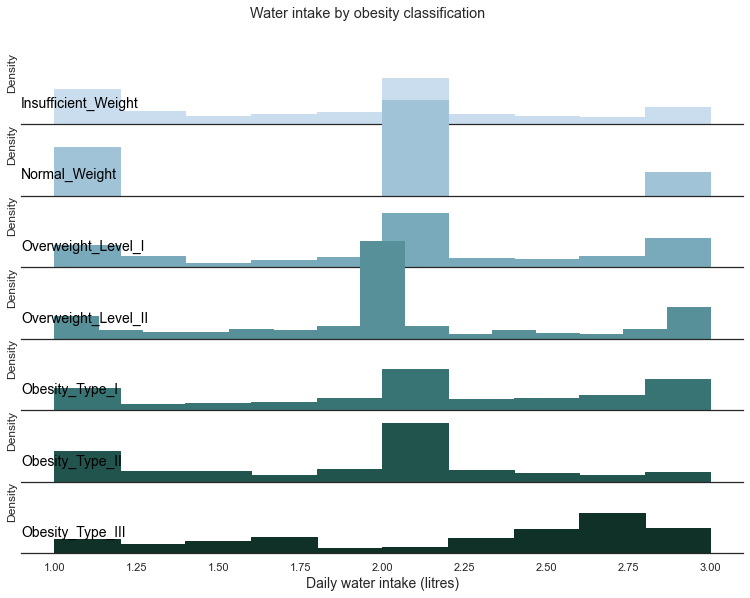

In [53]:
# Ridge plot - water intake (CH2O) by obesity classification
# CH20 dtype = float

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # This makes the background transparent
palette = sns.cubehelix_palette(7, start=2.2, rot=.2)

g = sns.FacetGrid(obesity, palette=palette, row="NObeyesdad", hue="NObeyesdad", aspect=9, height=1.2)
g.map_dataframe(sns.histplot, x="CH2O", element="step", stat="density", fill=True, alpha=1) # This paints/fills the inside area of the lines
#g.map_dataframe(sns.kdeplot, x="CH2O", color='black') # Draws another density plot to outline the first, 
                                                               # to differentiate them

# Create the plot labels    
def label(x, color, label):              
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=14,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "NObeyesdad")
    
g.fig.subplots_adjust(hspace=-.3)    # Controls the height space between the plots.
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)  # spines offset from the axes (a.k.a. "dropped spines")
g.set_axis_labels("Daily water intake (litres)",fontsize=14)

plt.suptitle('Water intake by obesity classification', y=0.98)
#g.fig.savefig("Water intake by obesity classification.jpg")
plt.show()

In order to make the water consumption feature more useful, I explored by making a new feature, which is water consumption per kg of bodyweight. More research would be needed to find out if this is a 'fair' measure, or an artefact of there being a limit to how much water a person is likely to drink in a day, regardless of their size and weight. 

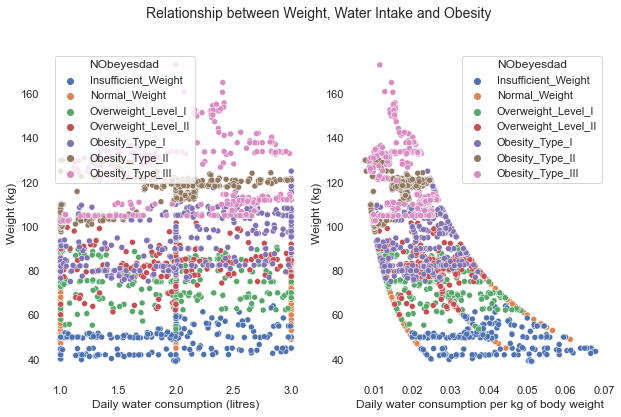

In [74]:
# Convert water consumption to litres per kg of body weight.

obesity['CH2O_adj'] = obesity['CH2O'] / obesity['Weight'] 

sns.set_theme(style="white")
fig, ax =plt.subplots(1,2,figsize=(10, 6))

sns.scatterplot(x='CH2O', y='Weight', data=obesity, hue='NObeyesdad', ax=ax[0])
sns.scatterplot(x='CH2O_adj', y='Weight', data=obesity, hue='NObeyesdad', ax=ax[1])
ax[0].set(xlabel="Daily water consumption (litres)", ylabel="Weight (kg)")
ax[1].set(xlabel="Daily water consumption per kg of body weight", ylabel="Weight (kg)")

sns.despine(left=True,bottom=True)
fig.suptitle("Relationship between Weight, Water Intake and Obesity", fontsize=14)
#fig.savefig("Weight_Water Intake_Obesity.jpg")
plt.show()

With this new feature there is a clear correlation between obesity level and water consumption per kg of body weight.  However, as with exercise, it is not obvious what is 'cause' and what is 'effect'.

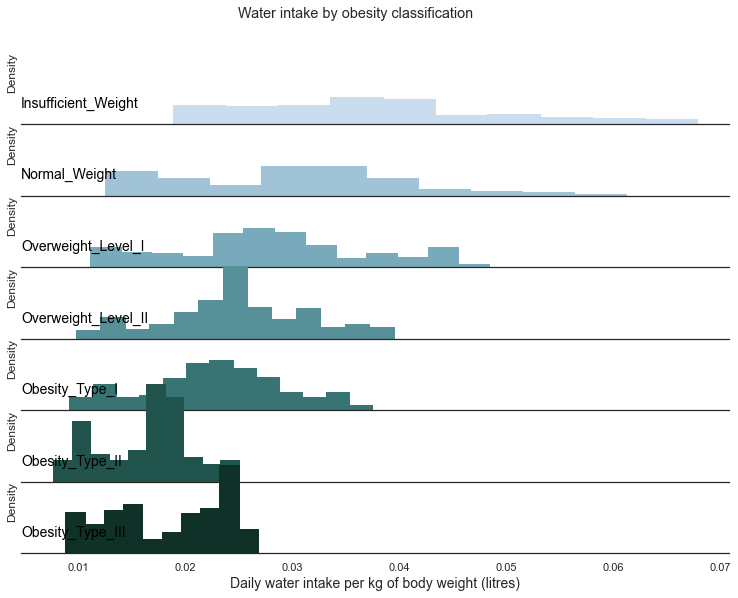

In [75]:
# Ridge plot - adjusted water intake (CH2O) by obesity classification
# CH20 dtype = float

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # This makes the background transparent
palette = sns.cubehelix_palette(7, start=2.2, rot=.2)

g = sns.FacetGrid(obesity, palette=palette, row="NObeyesdad", hue="NObeyesdad", aspect=9, height=1.2)
g.map_dataframe(sns.histplot, x="CH2O_adj", element="step", stat="density", fill=True, alpha=1) # This paints/fills the inside area of the lines
#g.map_dataframe(sns.kdeplot, x="CH2O_adj", color='black') # Draws another density plot to outline the first, 
                                                               # to differentiate them

# Create the plot labels    
def label(x, color, label):              
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=14,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "NObeyesdad")
    
g.fig.subplots_adjust(hspace=-.3)    # Controls the height space between the plots.
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)  # spines offset from the axes (a.k.a. "dropped spines")
g.set_axis_labels("Daily water intake per kg of body weight (litres)",fontsize=14)

plt.suptitle('Water intake by obesity classification', y=0.98)
#g.fig.savefig("Water Intake_Obesity_corrected_for_weight.jpg")
plt.show()

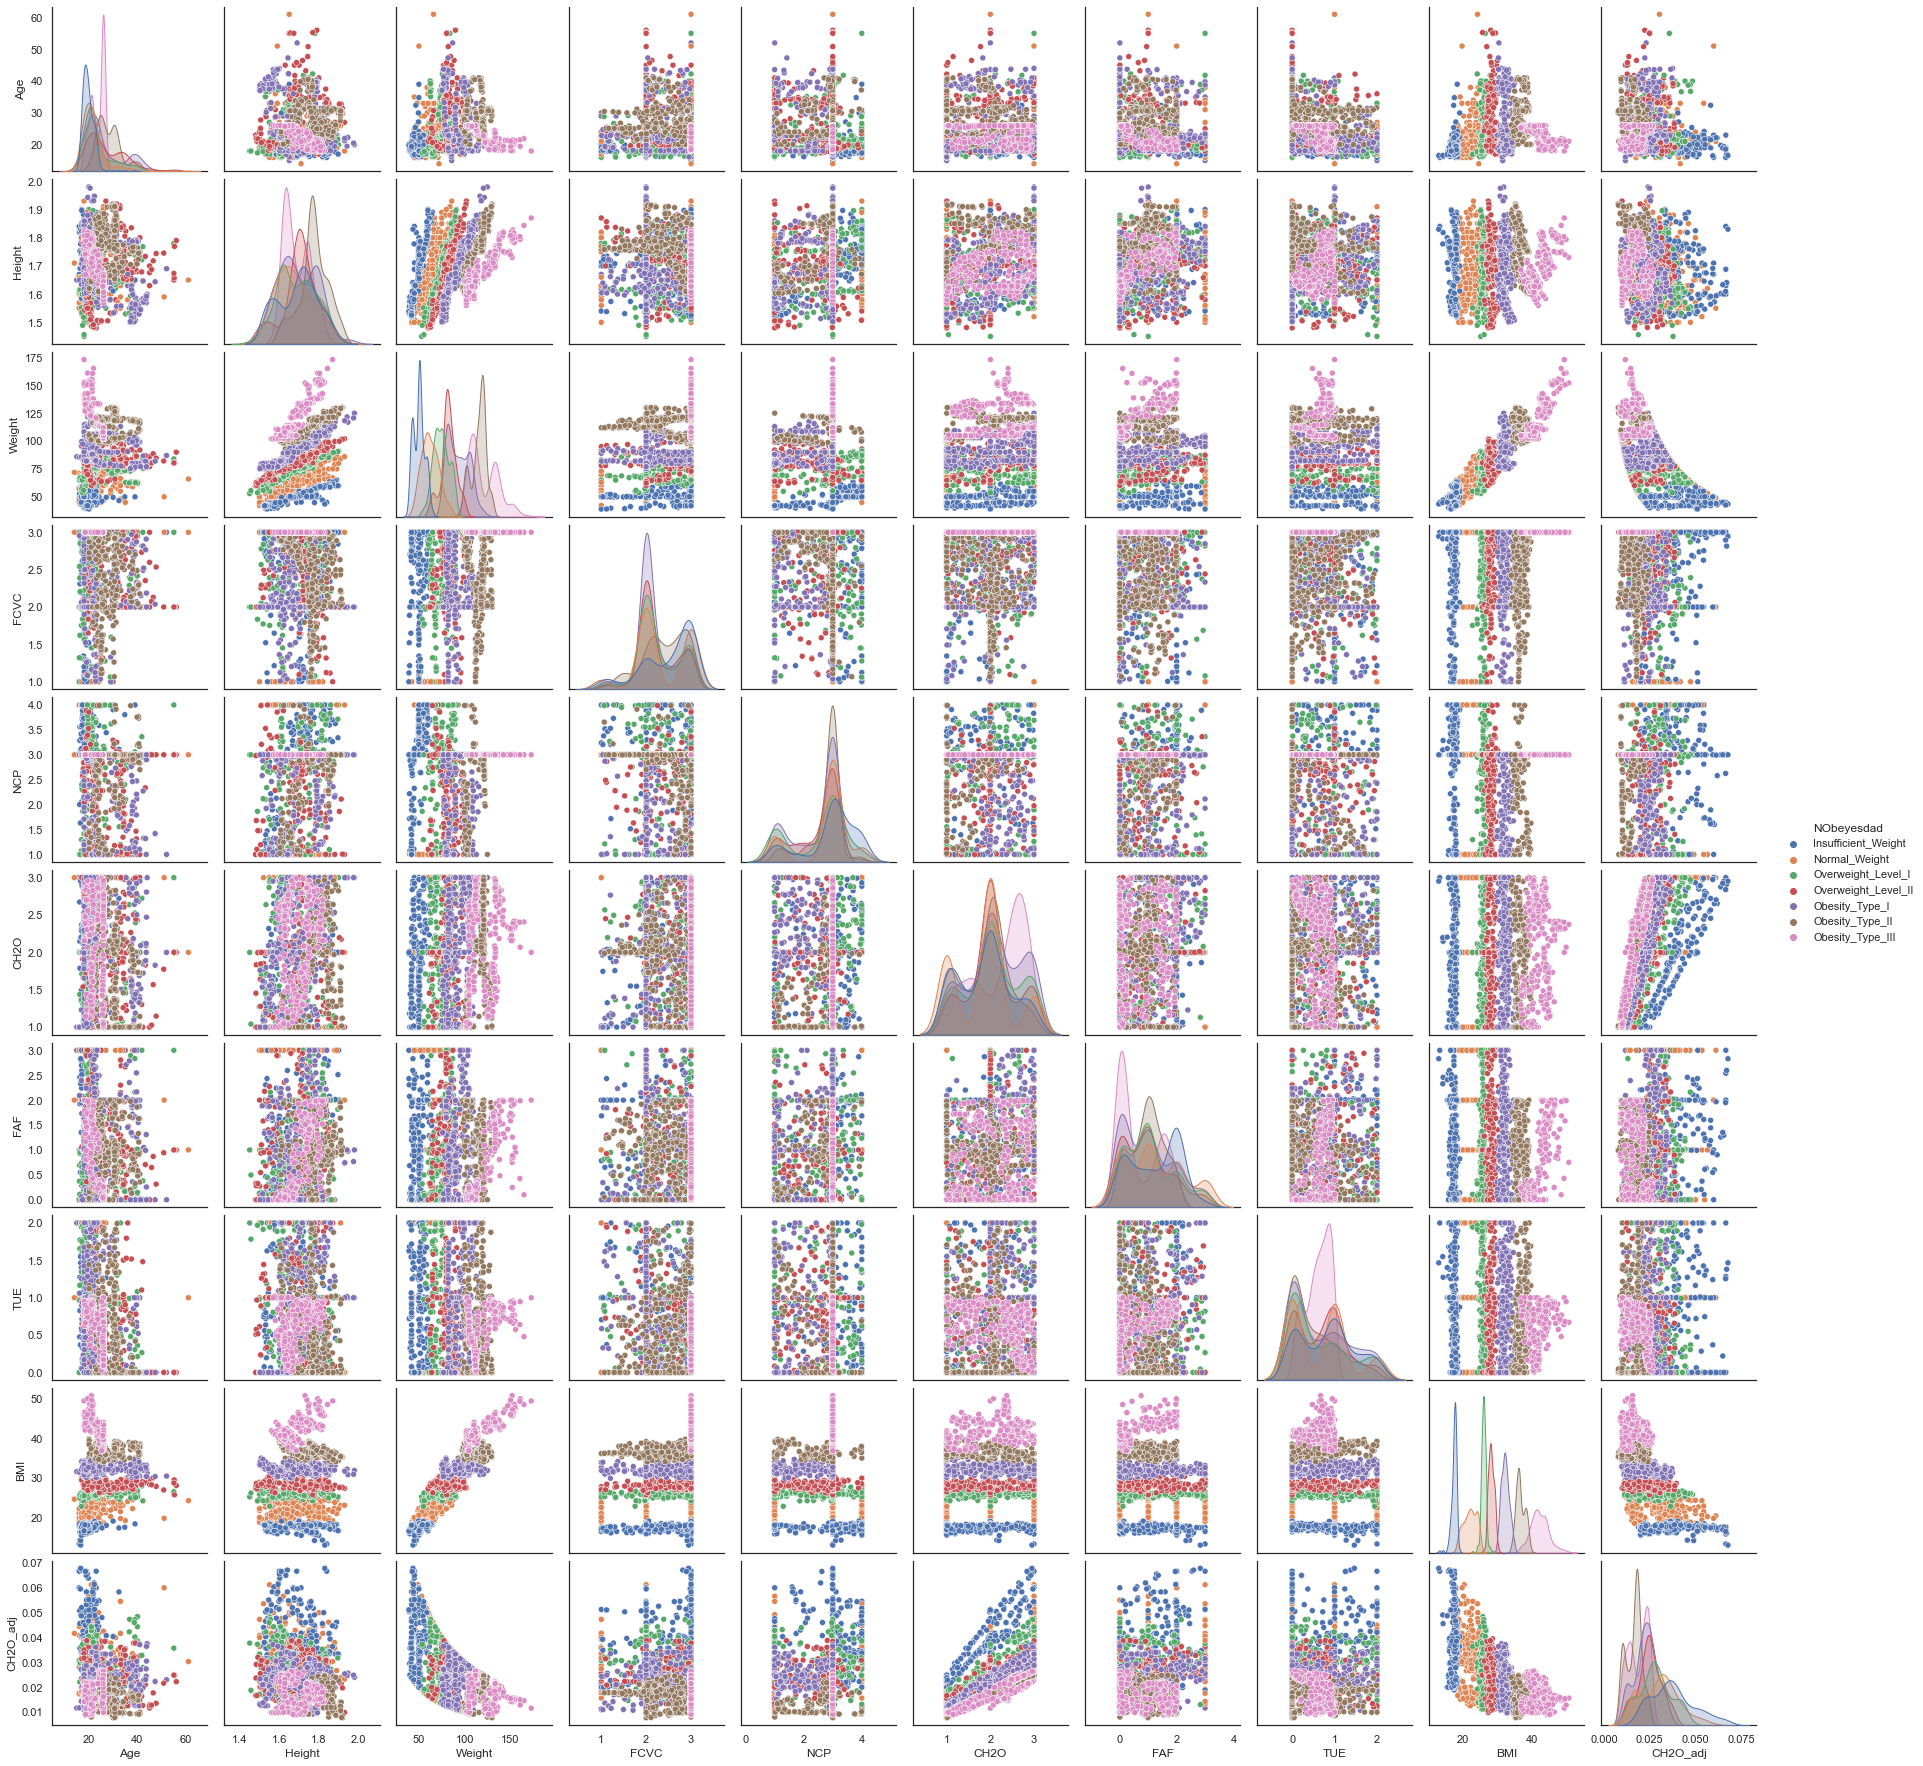

In [76]:
# Looking for any other relationships between the features.
# Datapoints are coloured by obesity level. 

p = sns.pairplot(data=obesity, hue="NObeyesdad")
#p.savefig("pairplots.jpg")

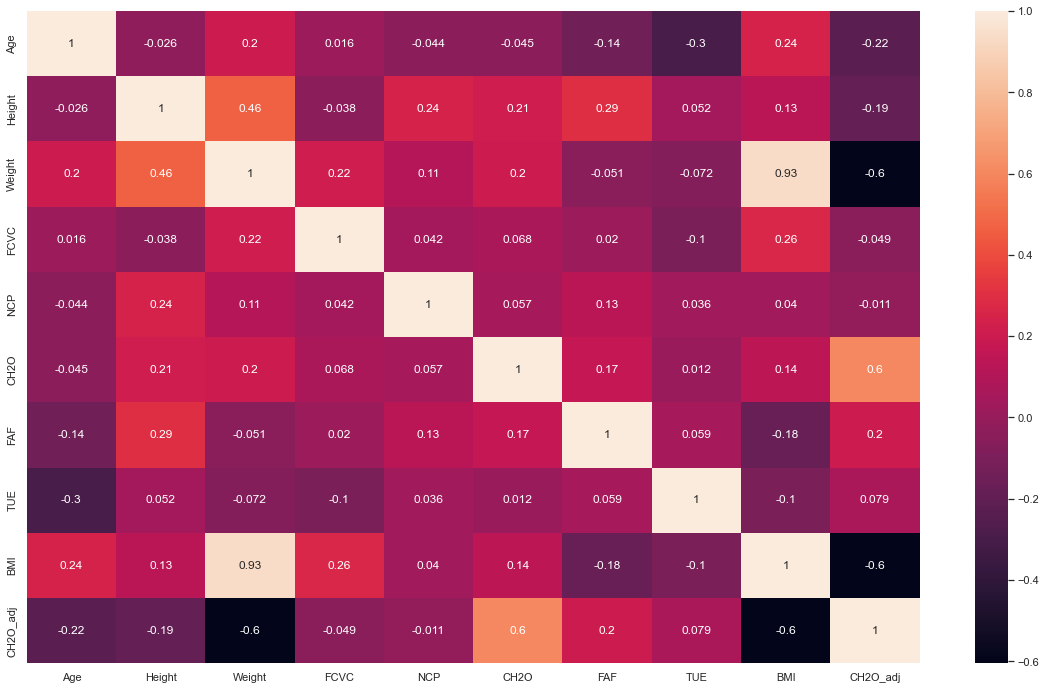

In [77]:
# Correlation matrix for numerical data
corr = obesity.corr()
fig, ax = plt.subplots(figsize=(20, 12))
ax = sns.heatmap(corr, annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#fig.savefig("Corr_matrix.jpg")

### The relationship between BMI and Obesity 

As expected, BMI correlates highly with obesity class.  However, it's predictive value is limited by the fact that it is generally used as a means of assigning a person to a weight class in the first place!  Also, we would wish to predict likelihood of *future* obesity, not who is already obese, which would be pretty pointless and obvious to the eye. 

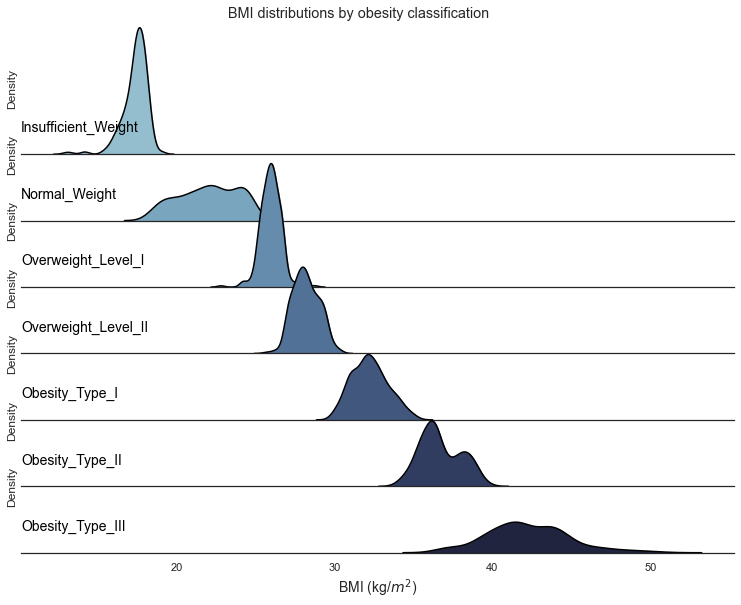

In [59]:
# Ridge plot - BMI distributions per 'obesity classification'

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # This makes the background transparent

palette = sns.cubehelix_palette(7, rot=-.2, light=.7)
g = sns.FacetGrid(obesity, palette=palette, row="NObeyesdad", hue="NObeyesdad", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="BMI", fill=True, alpha=1) # This paints/fills the inside area of the lines
g.map_dataframe(sns.kdeplot, x="BMI", color='black') # Draws another density plot to outline the first, 
                                                               # to differentiate them

# Create the plot labels    
def label(x, color, label):              
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=14,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "NObeyesdad")
    
g.fig.subplots_adjust(hspace=-.5)    # Controls the height space between the plots.
g.set_titles("")
g.set(yticks=[])
g.despine(left=True)  # spines offset from the axes (a.k.a. "dropped spines")
g.set_axis_labels("BMI (kg/$m^2$)",fontsize=14)

plt.suptitle('BMI distributions by obesity classification', y=0.98)
#g.fig.savefig("BMI_by_obesity_classification.jpg")
plt.show()

#### There is a slight tendency for BMI to increase with age, but this is not a striking relationship since the age band of the sampled population is narrow and most of the individuals are clustered in two foci on the contour plot below. 

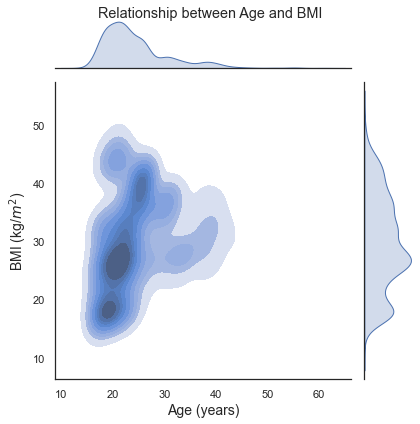

In [60]:
palette = sns.color_palette("mako", as_cmap=True)
p = sns.jointplot(x="Age", y="BMI", data=obesity, kind='kde', palette=palette, fill=True)
p.fig.suptitle("Relationship between Age and BMI")
p.ax_joint.set_xlabel("Age (years)",fontsize=14)
p.ax_joint.set_ylabel("BMI (kg/$m^2$)",fontsize=14)
p.ax_joint.collections[0].set_alpha(0.5)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
#p.fig.savefig("Age_v_BMI.jpg")
plt.show()

## Categorical data: replaced strings with binary integers

Reference: https://medium.com/p/5048997a5c79: discusses why scikit-learn 'OneHotEncoder' should be used in preference to Pandas 'get_dummies'
But after dicsussing with Matt, I decided to just use .replace()

In [78]:
# Applied 'replace()' to covert female/male and yes/no categories to 1/0:
obesity['Gender'] = obesity['Gender'].replace("Female", 1)
obesity['Gender'] = obesity['Gender'].replace("Male", 0)
obesity['family_history_with_overweight'] = obesity['family_history_with_overweight'].replace("yes", 1)
obesity['family_history_with_overweight'] = obesity['family_history_with_overweight'].replace("no", 0)
obesity['FAVC'] = obesity['FAVC'].replace("yes", 1)
obesity['FAVC'] = obesity['FAVC'].replace("no", 0)
obesity['SMOKE'] = obesity['SMOKE'].replace("yes", 1)
obesity['SMOKE'] = obesity['SMOKE'].replace("no", 0)
obesity['SCC'] = obesity['SCC'].replace("yes", 1)
obesity['SCC'] = obesity['SCC'].replace("no", 0)

In [79]:
# Applied pandas.get_dummies() to covert no/Sometimes/Frequently/Always categories to 0/1
obesity_dum = pd.get_dummies(obesity, prefix=['CAEC', 'CALC'], columns=['CAEC', 'CALC'], drop_first=True)

In [80]:
# Applied pandas.get_dummies() to covert MTRANS categories to 0/1
       
obesity_dum = pd.get_dummies(obesity_dum, prefix=['MTRANS'], columns=['MTRANS'], drop_first=True)

In [81]:
# Applied 'replace()' to covert the target column ('NObeyesdad') to ordinal integers to represent "obesity class"

obesity_dum['NObeyesdad'] = obesity_dum['NObeyesdad'].replace('Insufficient_Weight', 1)
obesity_dum['NObeyesdad'] = obesity_dum['NObeyesdad'].replace('Normal_Weight', 2)
obesity_dum['NObeyesdad'] = obesity_dum['NObeyesdad'].replace('Overweight_Level_I', 3)
obesity_dum['NObeyesdad'] = obesity_dum['NObeyesdad'].replace('Overweight_Level_II', 4)
obesity_dum['NObeyesdad'] = obesity_dum['NObeyesdad'].replace('Obesity_Type_I', 5)
obesity_dum['NObeyesdad'] = obesity_dum['NObeyesdad'].replace('Obesity_Type_II', 6)
obesity_dum['NObeyesdad'] = obesity_dum['NObeyesdad'].replace('Obesity_Type_III', 7)
obesity_dum.head()

Gender   Age  Height  Weight  family_history_with_overweight  FAVC  FCVC  \
0       1  21.0    1.62    64.0                               1     0   2.0   
1       1  21.0    1.52    56.0                               1     0   3.0   
2       0  23.0    1.80    77.0                               1     0   2.0   
3       0  27.0    1.80    87.0                               0     0   3.0   
4       0  22.0    1.78    89.8                               0     0   2.0   

   NCP  SMOKE  CH2O  ...  CAEC_Frequently  CAEC_Sometimes  CAEC_no  \
0  3.0      0   2.0  ...                0               1        0   
1  3.0      1   3.0  ...                0               1        0   
2  3.0      0   2.0  ...                0               1        0   
3  3.0      0   2.0  ...                0               1        0   
4  1.0      0   2.0  ...                0               1        0   

  CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Bike  MTRANS_Motorbike  \
0               0               0        1            0                 0   
1               0               1        0            0                 0   
2               1               0        0            0                 0   
3               1               0        0            0                 0   
4               0               1        0            0                 0   

   MTRANS_Public_Transportation  MTRANS_Walking  
0                             1               0  
1                             1               0  
2                             1               0  
3                             0               1  
4                             1               0  

[5 rows x 26 columns]

### Identifying the most important features

As expected, BMI is very highly correlated with obesity class (but not entirely correlated, indicating the BMI alone is not the sole determinant of obesity class - there are likely some highly muscular individuals with high BMI who don't classify as obese, e.g. many male athletes and body builders.

In [82]:
# By correlation coefficient (which appears to 'mirror' the answer obtained from Univariate Selection using SelectKBest()
corr2 = obesity_dum.corrwith(obesity_dum.NObeyesdad, axis=0, drop=False, method='pearson').sort_values(ascending=False)
corr2_short = corr2[((corr2 > 0.2)|(corr2 < -0.2))]
corr2_short.sort_values(ascending=False)
corr2_short

BMI                               0.977826
Weight                            0.913251
family_history_with_overweight    0.505148
CAEC_Sometimes                    0.453188
Age                               0.282913
FAVC                              0.247793
FCVC                              0.227759
CALC_Sometimes                    0.214067
CAEC_Frequently                  -0.418948
CH2O_adj                         -0.609571
dtype: float64

In [86]:
# Selected features and created the target data
X = obesity_dum[corr2_short.index.tolist()]
y = obesity_dum['NObeyesdad']

In [87]:
# Test-Train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (1688, 10)
X_test:  (423, 10)
y_train:  (1688,)
y_test:  (423,)


In [88]:
# Standardised the data 

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

### Gridsearch on Logistic Regression Model

In [71]:
# Applied 'Gridsearch' to find the best parameters for the Logistic Regression model

lr_params = {
    'penalty': ['l2'],    # 'penalty': ['l1','l2'],
    'C': [1, 10, 100]}

y_train = y_train.ravel()
logreg = LogisticRegression(dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
clf = GridSearchCV(estimator=logreg, param_grid=lr_params)
clf.fit(X_train_scaled, y_train)
sorted(clf.cv_results_.keys())

# Print results of gridsearch on Logistic Regression model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Best estimator: 	 LogisticRegression(C=100, max_iter=10000, random_state=1)
Best score: 	 	 0.9662370726739592
Best parameters: 	 {'C': 100, 'penalty': 'l2'}
Best scorer: 	 	 <function _passthrough_scorer at 0x7fb8b3ed0550>
No. CV splits: 	 	 5
Refit time: 	 	 0.24628686904907227
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 10


### Gridsearch on SVC Model

In [72]:
# Applied 'Gridsearch' to find the best parameters for the SVC model

svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

svc = SVC(C=1.0, kernel='rbf', gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, 
          cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', 
          break_ties=False, random_state=None)
clf = GridSearchCV(estimator=svc, param_grid=svc_params)
clf.fit(X_train_scaled, y_train)
sorted(clf.cv_results_.keys())

# Print results of gridsearch on SVC model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Best estimator: 	 SVC(C=10, gamma=0.001, kernel='linear', probability=True)
Best score: 	 	 0.969200920056889
Best parameters: 	 {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Best scorer: 	 	 <function _passthrough_scorer at 0x7fb8b3ed0550>
No. CV splits: 	 	 5
Refit time: 	 	 0.15881872177124023
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 10


### Gridsearch on Naive Bayes Model

In [73]:
# https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba

from sklearn.naive_bayes import GaussianNB

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GaussianNB() 
clf = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
clf.fit(X_train_scaled, y_train)

# Print results of gridsearch on SVC model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best estimator: 	 GaussianNB(var_smoothing=8.111308307896872e-05)
Best score: 	 	 0.9111298957452802
Best parameters: 	 {'var_smoothing': 8.111308307896872e-05}
Best scorer: 	 	 <function _passthrough_scorer at 0x7fb8b3ed0550>
No. CV splits: 	 	 10
Refit time: 	 	 0.003704071044921875
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 10


### Results of Gridsearch

### MODEL 1 - Logistic Regression 

In [75]:
logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=100, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

logreg.fit(X_train_scaled, y_train, sample_weight=None)
logreg.coef_
print("Intercept: ", logreg.intercept_[0])

score = logreg.score(X_train_scaled, y_train, sample_weight=None)
print("Accuracy score: ", score)

Intercept:  -41.992051136836196
Accuracy score:  0.9774881516587678


In [76]:
# Cross-validation
# Mean cross_validation score is similar to the accuracy score obtained from fitting the full training dataset

scores = cross_val_score(logreg, X_train_scaled, y_train, cv=10)
print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

CV scores:  [0.95266272 0.9704142  0.97633136 0.95857988 0.9704142  0.95857988
 0.9704142  0.98816568 0.97619048 0.95238095]
Mean CV score:  0.9674133558748943


In [77]:
# Testing how well the test data does on the model
# Accuracy score is lower than the accuracy score for the training data, which suggests a bit of overfitting

score2 = logreg.score(X_test_scaled, y_test, sample_weight=None)
print("Accuracy score (test data): ", score2)

# predict test class:
y_pred_class = logreg.predict(X_test_scaled)

# predicted test probability:
preds = logreg.predict_proba(X_test_scaled)[:,1]

Accuracy score (test data):  0.9432624113475178


In [78]:
# Creating the confusion matrix for this model

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y_test, y_pred_class)
df_logreg = pd.DataFrame(cm, index=index, columns=columns)
df_logreg

predicted_underweight  predicted_normal  \
is_underweight                       60                 1   
is_normal                             1                41   
is_overweight_I                       0                 1   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              3                        0   
is_overweight_I                       57                        3   
is_overweight_II                       3                       54   
is_obese_I                             0                        3   
is_obese_II                            0                        0   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    0  
is_overweight_I                   0                   0                    0  
is_overweight_II                  3                   0                    0  
is_obese_I                       72                   4                    0  
is_obese_II                       0                  53                    1  
is_obese_III                      0                   1                   62

In [79]:
# Classification report

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y_test, y_pred_class, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.98      0.98      0.98        61
       is_normal       0.95      0.91      0.93        45
 is_overweight_I       0.90      0.93      0.92        61
is_overweight_II       0.90      0.90      0.90        60
      is_obese_I       0.96      0.91      0.94        79
     is_obese_II       0.91      0.98      0.95        54
    is_obese_III       0.98      0.98      0.98        63

        accuracy                           0.94       423
       macro avg       0.94      0.94      0.94       423
    weighted avg       0.94      0.94      0.94       423



### MODEL 2 - Support Vector Classification (SVC)

In [80]:
svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

svc.fit(X_train_scaled, y_train, sample_weight=None)
score3 = svc.score(X_train_scaled, y_train, sample_weight=None)
print("Accuracy score: ", score3)

Accuracy score:  0.9768957345971564


In [81]:
# Cross-validation
# Mean cross_validation score is similar to the accuracy score obtained from fitting the full training dataset

scores = cross_val_score(svc, X_train_scaled, y_train, cv=10)
print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

CV scores:  [0.95857988 0.96449704 0.97633136 0.95857988 0.97633136 0.9704142
 0.9704142  0.98816568 0.97619048 0.95833333]
Mean CV score:  0.9697837418991266


In [82]:
# Testing how well the test data does on the model
# Accuracy score is slightly lower than the accuracy score for the training data; perhaps a bit of overfitting

score4 = svc.score(X_test_scaled, y_test, sample_weight=None)
print("Accuracy score (test data): ", score4)

# predict test class:
y_pred_class = svc.predict(X_test_scaled)

# predicted test probability:
preds = svc.predict_proba(X_test_scaled)[:,1]

Accuracy score (test data):  0.950354609929078


In [83]:
# Creating the confusion matrix for this model

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y_test, y_pred_class)
df_svc = pd.DataFrame(cm, index=index, columns=columns)
df_svc

predicted_underweight  predicted_normal  \
is_underweight                       60                 1   
is_normal                             1                43   
is_overweight_I                       0                 1   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              1                        0   
is_overweight_I                       55                        5   
is_overweight_II                       3                       55   
is_obese_I                             0                        2   
is_obese_II                            0                        0   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    0  
is_overweight_I                   0                   0                    0  
is_overweight_II                  2                   0                    0  
is_obese_I                       73                   4                    0  
is_obese_II                       0                  54                    0  
is_obese_III                      0                   1                   62

In [84]:
# Classification report

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y_test, y_pred_class, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.98      0.98      0.98        61
       is_normal       0.96      0.96      0.96        45
 is_overweight_I       0.93      0.90      0.92        61
is_overweight_II       0.89      0.92      0.90        60
      is_obese_I       0.97      0.92      0.95        79
     is_obese_II       0.92      1.00      0.96        54
    is_obese_III       1.00      0.98      0.99        63

        accuracy                           0.95       423
       macro avg       0.95      0.95      0.95       423
    weighted avg       0.95      0.95      0.95       423



### MODEL 3 - Gaussian Naive Bayes 

In [85]:
# Fitting the model to the training data

gnb = GaussianNB(var_smoothing=8.111308307896872e-05)

y_pred_bayes = gnb.fit(X_train_scaled, y_train).predict(X_train_scaled)
print("Number of mislabeled points out of a total %d points (training data) : %d" % (X_train_scaled.shape[0], (y_train != y_pred_bayes).sum()))
print("Accuracy (training data): ", (((X_train_scaled.shape[0]) - ((y_train != y_pred_bayes).sum())) / (X_train_scaled.shape[0])))

Number of mislabeled points out of a total 1688 points (training data) : 138
Accuracy (training data):  0.9182464454976303


In [95]:
# Cross-validation
# Mean cross_validation score is similar to the accuracy score obtained from fitting the full training dataset

scores = cross_val_score(gnb, X_train_scaled, y_train, cv=10)
print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

CV scores:  [0.91715976 0.89349112 0.88757396 0.88757396 0.87573964 0.88757396
 0.92307692 0.93491124 0.91666667 0.82142857]
Mean CV score:  0.8945195829811213


In [86]:
# Testing the model on the test data

y_pred_bayes_test = gnb.predict(X_test_scaled)
print("Number of mislabeled points out of a total %d points (test data) : %d" % (X_test_scaled.shape[0], (y_test != y_pred_bayes_test).sum()))
print("Accuracy (test data): ", (((X_test_scaled.shape[0]) - ((y_test != y_pred_bayes_test).sum())) / (X_test_scaled.shape[0])))

Number of mislabeled points out of a total 423 points (test data) : 51
Accuracy (test data):  0.8794326241134752


In [87]:
# Creating the confusion matrix for this model

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y_test, y_pred_bayes_test)
df_bayes = pd.DataFrame(cm, index=index, columns=columns)
df_bayes

predicted_underweight  predicted_normal  \
is_underweight                       59                 2   
is_normal                             5                32   
is_overweight_I                       0                 5   
is_overweight_II                      0                 2   
is_obese_I                            0                 1   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              8                        0   
is_overweight_I                       50                        6   
is_overweight_II                       1                       56   
is_obese_I                             0                        7   
is_obese_II                            0                        0   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    0  
is_overweight_I                   0                   0                    0  
is_overweight_II                  1                   0                    0  
is_obese_I                       61                   3                    7  
is_obese_II                       1                  52                    1  
is_obese_III                      0                   1                   62

In [88]:
# Classification report

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y_test, y_pred_bayes_test, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.92      0.97      0.94        61
       is_normal       0.76      0.71      0.74        45
 is_overweight_I       0.85      0.82      0.83        61
is_overweight_II       0.81      0.93      0.87        60
      is_obese_I       0.97      0.77      0.86        79
     is_obese_II       0.93      0.96      0.95        54
    is_obese_III       0.89      0.98      0.93        63

        accuracy                           0.88       423
       macro avg       0.88      0.88      0.87       423
    weighted avg       0.88      0.88      0.88       423



### MODEL 4 - Gaussian Naive Bayes (but with Unscaled Data)

In [92]:
# Gridsearch to find best parameters using unscaled data

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GaussianNB() 
clf = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)

# Print results of gridsearch on SVC model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best estimator: 	 GaussianNB(var_smoothing=0.0001)
Best score: 	 	 0.9449070160608622
Best parameters: 	 {'var_smoothing': 0.0001}
Best scorer: 	 	 <function _passthrough_scorer at 0x7ffdda24ae50>
No. CV splits: 	 	 10
Refit time: 	 	 0.003834962844848633
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 10


In [90]:
# Fitting the model to the training data

gnb = GaussianNB(var_smoothing=0.0001)

y_pred_bayes = gnb.fit(X_train, y_train).predict(X_train)
print("Number of mislabeled points out of a total %d points (training data) : %d" % (X_train.shape[0], (y_train != y_pred_bayes).sum()))
print("Accuracy (training data): ", (((X_train.shape[0]) - ((y_train != y_pred_bayes).sum())) / (X_train.shape[0])))

Number of mislabeled points out of a total 1688 points (training data) : 90
Accuracy (training data):  0.9466824644549763


In [94]:
# Cross-validation
# Mean cross_validation score is similar to the accuracy score obtained from fitting the full training dataset

scores = cross_val_score(gnb, X_train, y_train, cv=10)
print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

CV scores:  [0.91715976 0.91715976 0.89940828 0.89349112 0.87573964 0.89940828
 0.92307692 0.93491124 0.91666667 0.875     ]
Mean CV score:  0.9052021696252466


In [91]:
# Testing the model on the test data

y_pred_bayes_test = gnb.predict(X_test)
print("Number of mislabeled points out of a total %d points (test data) : %d" % (X_test.shape[0], (y_test != y_pred_bayes_test).sum()))
print("Accuracy (test data): ", (((X_test.shape[0]) - ((y_test != y_pred_bayes_test).sum())) / (X_test.shape[0])))

Number of mislabeled points out of a total 423 points (test data) : 34
Accuracy (test data):  0.9196217494089834


In [92]:
# Creating the confusion matrix for this model

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y_test, y_pred_bayes_test)
df_bayes_2 = pd.DataFrame(cm, index=index, columns=columns)
df_bayes_2

predicted_underweight  predicted_normal  \
is_underweight                       59                 2   
is_normal                             5                31   
is_overweight_I                       0                 3   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              9                        0   
is_overweight_I                       54                        4   
is_overweight_II                       2                       57   
is_obese_I                             0                        1   
is_obese_II                            0                        0   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    0  
is_overweight_I                   0                   0                    0  
is_overweight_II                  1                   0                    0  
is_obese_I                       73                   5                    0  
is_obese_II                       0                  54                    0  
is_obese_III                      0                   2                   61

In [93]:
# Classification report

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y_test, y_pred_bayes_test, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.92      0.97      0.94        61
       is_normal       0.86      0.69      0.77        45
 is_overweight_I       0.83      0.89      0.86        61
is_overweight_II       0.92      0.95      0.93        60
      is_obese_I       0.99      0.92      0.95        79
     is_obese_II       0.89      1.00      0.94        54
    is_obese_III       1.00      0.97      0.98        63

        accuracy                           0.92       423
       macro avg       0.91      0.91      0.91       423
    weighted avg       0.92      0.92      0.92       423



### Conclusions

### But are all 10 of these features required?  How do the models do with just the leading predictor (BMI)?  How much do the other features contribute to the accuracy of the predictions?

### MODEL 5 - Support Vector Classification (SVC) with just One Feature

In [96]:
X2 = obesity_dum[["BMI"]]
y2 = obesity_dum["NObeyesdad"]
scaler = StandardScaler()
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 1)
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

In [98]:
svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

svc.fit(X2_train_scaled, y2_train, sample_weight=None)
score5 = svc.score(X2_train_scaled, y2_train, sample_weight=None)
print("Accuracy score (training, 1 feature): ", score5)

scores = cross_val_score(svc, X2_train_scaled, y2_train, cv=10)
#print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

score6 = svc.score(X2_test_scaled, y2_test, sample_weight=None)
print("Accuracy score (test, 1 feature): ", score6)

Accuracy score (training, 1 feature):  0.9466824644549763
Mean CV score:  0.9461045364891518
Accuracy score (test, 1 feature):  0.9243498817966903


The model is still 94% accurate using just BMI.  The other features add just 3% to the accuracy.

In [99]:
# Support Vector Classification (SVC) with just Two Features

X3 = obesity_dum[["BMI","Weight"]]
y3 = obesity_dum["NObeyesdad"]
scaler = StandardScaler()
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.2, random_state = 1)
X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)

svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

svc.fit(X3_train_scaled, y3_train, sample_weight=None)

score7 = svc.score(X3_train_scaled, y3_train, sample_weight=None)
print("Accuracy score (training, 2 best features): ", score7)

scores = cross_val_score(svc, X3_train_scaled, y3_train, cv=10)
#print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

score8 = svc.score(X3_test_scaled, y3_test, sample_weight=None)
print("Accuracy score (test, 2 best features): ", score8)

Accuracy score (training, 2 best features):  0.9537914691943128
Mean CV score:  0.9490736827275288
Accuracy score (test, 2 best features):  0.9385342789598109


In [100]:
# Support Vector Classification (SVC) with just Three Features

X4 = obesity_dum[["BMI","Weight","CH2O_adj"]]
y4 = obesity_dum["NObeyesdad"]
scaler = StandardScaler()
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state = 1)
X4_train_scaled = scaler.fit_transform(X4_train)
X4_test_scaled = scaler.transform(X4_test)

svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

svc.fit(X4_train_scaled, y4_train, sample_weight=None)

score9 = svc.score(X4_train_scaled, y4_train, sample_weight=None)
print("Accuracy score (training, 3 best features): ", score9)

scores = cross_val_score(svc, X4_train_scaled, y4_train, cv=10)
#print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

score10 = svc.score(X4_test_scaled, y4_test, sample_weight=None)
print("Accuracy score (test, 3 best features): ", score10)

Accuracy score (training, 3 best features):  0.9567535545023697
Mean CV score:  0.9502535925612848
Accuracy score (test, 3 best features):  0.9408983451536643


In [101]:
# Support Vector Classification (SVC) with just Four Features

X5 = obesity_dum[["BMI","Weight","CH2O_adj","family_history_with_overweight"]]
y5 = obesity_dum["NObeyesdad"]
scaler = StandardScaler()
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.2, random_state = 1)
X5_train_scaled = scaler.fit_transform(X5_train)
X5_test_scaled = scaler.transform(X5_test)

svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

svc.fit(X5_train_scaled, y5_train, sample_weight=None)

score11 = svc.score(X5_train_scaled, y5_train, sample_weight=None)
print("Accuracy score (training, 4 best features): ", score11)

scores = cross_val_score(svc, X3_train_scaled, y3_train, cv=10)
#print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

score12 = svc.score(X5_test_scaled, y5_test, sample_weight=None)
print("Accuracy score (test, 4 best features): ", score12)

Accuracy score (training, 4 best features):  0.9585308056872038
Mean CV score:  0.9490736827275288
Accuracy score (test, 4 best features):  0.9432624113475178


### Next Question: How much do the models improve when *ALL* features are used?

### MODEL 6 - Support Vector Classification (SVC) with *ALL* Features

In [109]:
# Prepare the data
X6 = obesity_dum.drop(columns="NObeyesdad")
y6 = obesity_dum["NObeyesdad"]

In [110]:
# Scale and fit model
scaler = StandardScaler()
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size = 0.2, random_state = 1)
X6_train_scaled = scaler.fit_transform(X6_train)
X6_test_scaled = scaler.transform(X6_test)

svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
          cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', 
          break_ties=False, random_state=1)

svc.fit(X6_train_scaled, y6_train, sample_weight=None)

score13 = svc.score(X6_train_scaled, y6_train, sample_weight=None)
print("Accuracy score (training data, all features): ", score13)

Accuracy score (training data, all features):  0.9869668246445498


In [111]:
# Cross-validation
# Mean cross_validation score is very close to the accuracy score obtained from fitting the full training dataset

scores2 = cross_val_score(svc, X6_train_scaled, y6_train, cv=10)
print("CV scores: ", scores2)
print("Mean CV score: ", np.mean(scores2))

CV scores:  [0.94674556 0.97633136 0.97633136 0.96449704 0.9704142  0.95857988
 0.97633136 0.9704142  0.96428571 0.96428571]
Mean CV score:  0.9668216398985627


In [113]:
# Testing how well the test data does on the model
# Accuracy score is slightly lower than the accuracy score for the training data; perhaps a bit of overfitting

score14 = svc.score(X6_test_scaled, y6_test, sample_weight=None)
print("Accuracy score (test data, all features): ", score14)

# predict test class:
y6_pred_class = svc.predict(X6_test_scaled)

# predicted test probability:
#preds6 = svc.predict_proba(X6_test_scaled)[:,1]

Accuracy score (test data, all features):  0.9550827423167849


In [114]:
# Creating the confusion matrix for this model

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y6_test, y6_pred_class)
df6_svc = pd.DataFrame(cm, index=index, columns=columns)
df6_svc

predicted_underweight  predicted_normal  \
is_underweight                       60                 1   
is_normal                             2                41   
is_overweight_I                       0                 1   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              2                        0   
is_overweight_I                       56                        4   
is_overweight_II                       2                       56   
is_obese_I                             0                        2   
is_obese_II                            0                        0   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    0  
is_overweight_I                   0                   0                    0  
is_overweight_II                  2                   0                    0  
is_obese_I                       75                   2                    0  
is_obese_II                       0                  54                    0  
is_obese_III                      0                   1                   62

In [115]:
# Classification report

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y6_test, y6_pred_class, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.97      0.98      0.98        61
       is_normal       0.95      0.91      0.93        45
 is_overweight_I       0.93      0.92      0.93        61
is_overweight_II       0.90      0.93      0.92        60
      is_obese_I       0.97      0.95      0.96        79
     is_obese_II       0.95      1.00      0.97        54
    is_obese_III       1.00      0.98      0.99        63

        accuracy                           0.96       423
       macro avg       0.95      0.95      0.95       423
    weighted avg       0.96      0.96      0.96       423



### MODEL 7 - Logistic Regression with *ALL* features

In [116]:
logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=100, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

logreg.fit(X6_train_scaled, y6_train, sample_weight=None)
logreg.coef_
print("Intercept: ", logreg.intercept_[0])

score6 = logreg.score(X6_train_scaled, y6_train, sample_weight=None)
print("Accuracy score (train data): ", score6)

Intercept:  -50.39640552302779
Accuracy score (train data):  0.9875592417061612


In [117]:
# Cross-validation
# Mean cross_validation score is similar to the accuracy score obtained from fitting the full training dataset

scores = cross_val_score(logreg, X6_train_scaled, y6_train, cv=10)
print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

CV scores:  [0.93491124 0.9704142  0.97633136 0.94674556 0.95266272 0.92899408
 0.9704142  0.97633136 0.95833333 0.95238095]
Mean CV score:  0.9567519019442097


In [118]:
# Testing how well the test data does on the model
# Accuracy score is lower than the accuracy score for the training data, which suggests a bit of overfitting

score7 = logreg.score(X6_test_scaled, y6_test, sample_weight=None)
print("Accuracy score (test data): ", score7)

# predict test class:
y7_pred_class = logreg.predict(X6_test_scaled)

# predicted test probability:
preds7 = logreg.predict_proba(X6_test_scaled)[:,1]

Accuracy score (test data):  0.9479905437352246


In [119]:
# Creating the confusion matrix for this model

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y6_test, y7_pred_class)
df_logreg = pd.DataFrame(cm, index=index, columns=columns)
df_logreg

predicted_underweight  predicted_normal  \
is_underweight                       60                 1   
is_normal                             2                40   
is_overweight_I                       0                 1   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              3                        0   
is_overweight_I                       55                        5   
is_overweight_II                       2                       56   
is_obese_I                             0                        2   
is_obese_II                            0                        0   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    0  
is_overweight_I                   0                   0                    0  
is_overweight_II                  2                   0                    0  
is_obese_I                       75                   2                    0  
is_obese_II                       0                  54                    0  
is_obese_III                      0                   2                   61

In [120]:
# Classification report

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y6_test, y7_pred_class, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.97      0.98      0.98        61
       is_normal       0.95      0.89      0.92        45
 is_overweight_I       0.92      0.90      0.91        61
is_overweight_II       0.89      0.93      0.91        60
      is_obese_I       0.97      0.95      0.96        79
     is_obese_II       0.93      1.00      0.96        54
    is_obese_III       1.00      0.97      0.98        63

        accuracy                           0.95       423
       macro avg       0.95      0.95      0.95       423
    weighted avg       0.95      0.95      0.95       423



### MODEL 8 - Naive Bayes (Gaussian NB) with *ALL* Features

In [121]:
# Fitting the model to the training data
# scaler = StandardScaler() # Model performed better with unscaled data, so won't scale

gnb = GaussianNB(var_smoothing=0.0001)

y6_pred_bayes = gnb.fit(X6_train, y6_train).predict(X6_train)
print("Number of mislabeled points out of a total %d points (training data) : %d" % (X6_train.shape[0], (y6_train != y6_pred_bayes).sum()))
print("Accuracy (training data): ", (((X6_train.shape[0]) - ((y6_train != y6_pred_bayes).sum())) / (X6_train.shape[0])))

Number of mislabeled points out of a total 1688 points (training data) : 90
Accuracy (training data):  0.9466824644549763


In [122]:
# Cross-validation
# Mean cross_validation score is the same as the accuracy score obtained from fitting the full training dataset

scores8 = cross_val_score(gnb, X6_train, y6_train, cv=10)
print("CV scores: ", scores8)
print("Mean CV score: ", np.mean(scores8))

CV scores:  [0.9408284  0.92307692 0.95266272 0.94674556 0.92307692 0.94674556
 0.93491124 0.9704142  0.9702381  0.91666667]
Mean CV score:  0.9425366300366299


In [123]:
# Testing the model on the test data

y6_pred_bayes_test = gnb.predict(X6_test)
print("Number of mislabeled points out of a total %d points (test data) : %d" % (X6_test.shape[0], (y6_test != y6_pred_bayes_test).sum()))
print("Accuracy (test data): ", (((X6_test.shape[0]) - ((y6_test != y6_pred_bayes_test).sum())) / (X6_test.shape[0])))

Number of mislabeled points out of a total 423 points (test data) : 40
Accuracy (test data):  0.9054373522458629


In [124]:
# Creating the confusion matrix for this model

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y6_test, y6_pred_bayes_test)
df_bayes_8 = pd.DataFrame(cm, index=index, columns=columns)
df_bayes_8

predicted_underweight  predicted_normal  \
is_underweight                       59                 2   
is_normal                             6                32   
is_overweight_I                       0                 4   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              7                        0   
is_overweight_I                       48                        9   
is_overweight_II                       2                       57   
is_obese_I                             0                        1   
is_obese_II                            0                        0   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    0  
is_overweight_I                   0                   0                    0  
is_overweight_II                  1                   0                    0  
is_obese_I                       71                   7                    0  
is_obese_II                       0                  54                    0  
is_obese_III                      0                   1                   62

In [125]:
# Classification report

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y6_test, y6_pred_bayes_test, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.91      0.97      0.94        61
       is_normal       0.84      0.71      0.77        45
 is_overweight_I       0.84      0.79      0.81        61
is_overweight_II       0.85      0.95      0.90        60
      is_obese_I       0.99      0.90      0.94        79
     is_obese_II       0.87      1.00      0.93        54
    is_obese_III       1.00      0.98      0.99        63

        accuracy                           0.91       423
       macro avg       0.90      0.90      0.90       423
    weighted avg       0.91      0.91      0.90       423



### Conclusions

### Learning Curves for SVC, Logistic Regression & Bayes Models - with *ALL* Features

In [126]:
# SVC model, *all* features, c=10, kernel=linear, gamma=0.001

# array 1 = number of samples in each training set
# array 2 = training scores (5 training sizes, cv=5)
# array 3 = test scores
# array 4 = fit times for training data

train_sizes=[0.1, 0.33, 0.55, 0.78, 1.]

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(svc, X6_train_scaled, y6_train, groups=None, 
                                                                      train_sizes=train_sizes, cv=None, 
                                                                      scoring=None, exploit_incremental_learning=False, 
                                                                      n_jobs=None, pre_dispatch='all', verbose=0, shuffle=False, 
                                                                      random_state=1, return_times=True, fit_params=None)

print("Train sizes: ", train_sizes)
print("Mean train score: ", np.nanmean(train_scores), "+/-", np.nanstd(train_scores))
print("Mean test score: ", np.nanmean(test_scores), "+/-", np.nanstd(test_scores)) 
print("Mean fit time: ", np.mean(fit_times), "+/-", np.std(fit_times))

Train sizes:  [ 135  445  742 1053 1350]
Mean train score:  0.9939596821272463 +/- 0.005347992925419359
Mean test score:  0.9169392305936473 +/- 0.07465354674657343
Mean fit time:  0.026071996688842775 +/- 0.019273620656216853


In [127]:
# Gaussian Naive Bayes model, *all* features, var_smoothing=0.0001

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(gnb, X6_train, y6_train, groups=None, 
                                                                      train_sizes=train_sizes, cv=None, 
                                                                      scoring=None, exploit_incremental_learning=False, 
                                                                      n_jobs=None, pre_dispatch='all', verbose=0, shuffle=False, 
                                                                      random_state=1, return_times=True, fit_params=None)

print("Train sizes: ", train_sizes)
print("Mean train score: ", np.nanmean(train_scores), "+/-", np.nanstd(train_scores))
print("Mean test score: ", np.nanmean(test_scores), "+/-", np.nanstd(test_scores)) 
print("Mean fit time: ", np.mean(fit_times), "+/-", np.std(fit_times))

Train sizes:  [ 135  445  742 1053 1350]
Mean train score:  0.9445088051206063 +/- 0.008292434380000512
Mean test score:  0.9273695854476497 +/- 0.022252575109406165
Mean fit time:  0.0022417736053466798 +/- 0.001360127270427277


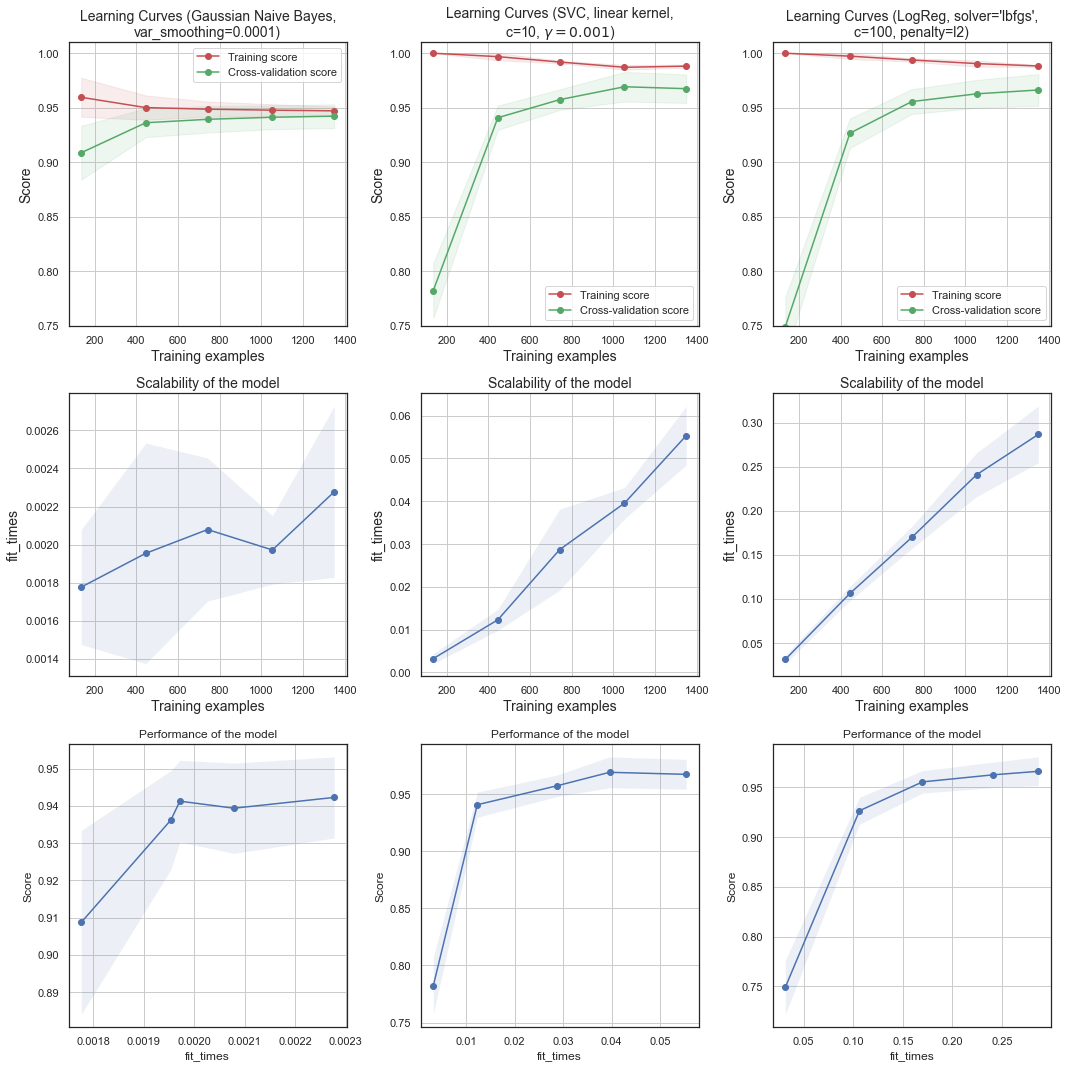

In [128]:
# Plot learning curves
# Code reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

from textwrap import wrap
from sklearn.model_selection import ShuffleSplit
sns.set_theme(style="white")

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    n_jobs=None,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(2, 3, figsize=(20, 5))

    axes[0].set_title('\n'.join(wrap(title,40)),fontsize=14)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples",fontsize=14)
    axes[0].set_ylabel("Score",fontsize=14)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.nanmean(train_scores, axis=1)
    train_scores_std = np.nanstd(train_scores, axis=1)
    test_scores_mean = np.nanmean(test_scores, axis=1)
    test_scores_std = np.nanstd(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples", fontsize=14)
    axes[1].set_ylabel("fit_times", fontsize=14)
    axes[1].set_title("Scalability of the model", fontsize=14)

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 3, figsize=(15, 15))

title = "Learning Curves (Gaussian Naive Bayes, var_smoothing=0.0001)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB(var_smoothing=0.0001)
plot_learning_curve(
    estimator, title, X6_train, y6_train, axes=axes[:, 0], ylim=(0.75, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVC, linear kernel, c=10, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=False, 
                      tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, 
                      decision_function_shape='ovr', break_ties=False, random_state=1)
estimator = svc 
plot_learning_curve(
    estimator, title, X6_train_scaled, y6_train, axes=axes[:, 1], ylim=(0.75, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (LogReg, solver='lbfgs', c=100, penalty=l2)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=100, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimator = logreg 
plot_learning_curve(
    estimator, title, X6_train_scaled, y6_train, 
    axes=axes[:, 2], ylim=(0.75, 1.01), cv=cv, n_jobs=4
)
fig.tight_layout()
#fig.savefig("learning_curves.jpg")
plt.show()

The learning curves show that the Gaussian NB model will perform best with smaller amounts of data, as the training score and cross-validation score converges earlier. The Logistic Regression model and SVC model achieve higher accuracy scores, though the cross-validation scores never converge fully.  The LogReg model starts to decrease performance when the number of observations increases above 1100. 

## HOW ACCURATELY CAN WE PREDICT OBESITY WITHOUT THE BMI AND WEIGHT VARIABLES?

In order to be a useful model, it needs to be able to predict obesity from behavioural variablss and not simply by the variables upon which obesity itself is largely defined.  I started by removing just BMI and Weight, to see how the model will hold up without these features. 

### MODEL 9 - Support Vector Classification (SVC) without BMI and Weight Features

In [134]:
# Dropped BMI, Weight and Obesity Class from the dataset
X9 = obesity_dum.drop(["BMI","Weight","NObeyesdad"],axis=1)
y9 = obesity_dum["NObeyesdad"]

In [130]:
scaler = StandardScaler()
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, y9, test_size = 0.2, random_state = 1)
X9_train_scaled = scaler.fit_transform(X9_train)
X9_test_scaled = scaler.transform(X9_test)

In [131]:
# Applied 'Gridsearch' to find the best parameters for the SVC model without the BMI and Weight features
# No change in best hyperparameters compared with the earlier models

svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

svc = SVC(C=1.0, kernel='rbf', gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, 
          cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', 
          break_ties=False, random_state=None)
clf = GridSearchCV(estimator=svc, param_grid=svc_params)
clf.fit(X9_train_scaled, y9_train)
sorted(clf.cv_results_.keys())

# Print results of gridsearch on SVC model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Best estimator: 	 SVC(C=10, gamma=0.001, kernel='linear')
Best score: 	 	 0.9146910610503397
Best parameters: 	 {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
Best scorer: 	 	 <function _passthrough_scorer at 0x7ffdda24ae50>
No. CV splits: 	 	 5
Refit time: 	 	 0.13920283317565918
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 23


In [132]:
# Fitting SVC model to data (without the BMI and Weight features)

svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=False, 
          tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, 
          decision_function_shape='ovr', break_ties=False, random_state=1)

svc.fit(X9_train_scaled, y9_train, sample_weight=None)

score14 = svc.score(X9_train_scaled, y9_train, sample_weight=None)
print("Accuracy score (training data, all features): ", score14)

Accuracy score (training data, all features):  0.9460900473933649


In [135]:
# Cross-validation (SVC model without the BMI and Weight features)
# Mean cross_validation score is lower than the accuracy score obtained from fitting the full training dataset

scores15 = cross_val_score(svc, X9_train_scaled, y9_train, cv=10)
print("CV scores: ", scores15)
print("Mean CV score: ", np.mean(scores15))

CV scores:  [0.92899408 0.9112426  0.92899408 0.92307692 0.9112426  0.88757396
 0.90532544 0.91715976 0.92261905 0.91666667]
Mean CV score:  0.9152895181741334


In [137]:
# Testing how well the test data does on the SVC model without the BMI and Weight features
# Accuracy score is lower than the accuracy score for the training data; suggests overfitting

score16 = svc.score(X9_test_scaled, y9_test, sample_weight=None)
print("Accuracy score (test data, all features): ", score16)

# predict test class:
y9_pred_class = svc.predict(X9_test_scaled)

# predicted test probability:
#preds9 = svc.predict_proba(X9_test_scaled)[:,1]

Accuracy score (test data, all features):  0.8865248226950354


In [138]:
# Confusion matrix (SVC model without the BMI and Weight features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y9_test, y9_pred_class)
df9_svc = pd.DataFrame(cm, index=index, columns=columns)
df9_svc

predicted_underweight  predicted_normal  \
is_underweight                       57                 4   
is_normal                             5                32   
is_overweight_I                       0                 6   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              6                        2   
is_overweight_I                       50                        5   
is_overweight_II                       4                       55   
is_obese_I                             0                       10   
is_obese_II                            0                        0   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    0  
is_overweight_I                   0                   0                    0  
is_overweight_II                  1                   0                    0  
is_obese_I                       66                   3                    0  
is_obese_II                       0                  54                    0  
is_obese_III                      1                   1                   61

In [139]:
# Classification report (SVC model without the BMI and Weight features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y9_test, y9_pred_class, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.92      0.93      0.93        61
       is_normal       0.76      0.71      0.74        45
 is_overweight_I       0.83      0.82      0.83        61
is_overweight_II       0.76      0.92      0.83        60
      is_obese_I       0.97      0.84      0.90        79
     is_obese_II       0.93      1.00      0.96        54
    is_obese_III       1.00      0.97      0.98        63

        accuracy                           0.89       423
       macro avg       0.88      0.88      0.88       423
    weighted avg       0.89      0.89      0.89       423



### MODEL 10 - Logistic Regression without BMI and Weight Features

In [140]:
# Applied 'Gridsearch' to find the best parameters for the Logistic Regression model without BMI and Weight Features

lr_params = {
    'penalty': ['l2'],    # 'penalty': ['l1','l2'],
    'C': [1, 10, 100]}

y9_train = y9_train.ravel()
svc = LogisticRegression(dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
clf = GridSearchCV(estimator=logreg, param_grid=lr_params)
clf.fit(X9_train_scaled, y9_train)
sorted(clf.cv_results_.keys())

# Print results of gridsearch on Logistic Regression model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Best estimator: 	 LogisticRegression(C=100, max_iter=10000, random_state=1)
Best score: 	 	 0.9075904693343635
Best parameters: 	 {'C': 100, 'penalty': 'l2'}
Best scorer: 	 	 <function _passthrough_scorer at 0x7ffdda24ae50>
No. CV splits: 	 	 5
Refit time: 	 	 0.3424661159515381
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 23


In [142]:
# Fitted Logistic Regression model to data (without the BMI and Weight features)

logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=100, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

logreg.fit(X9_train_scaled, y9_train, sample_weight=None)
logreg.coef_
print("Intercept: ", logreg.intercept_[0])

score17 = logreg.score(X9_train_scaled, y9_train, sample_weight=None)
print("Accuracy score (train data): ", score17)

# Cross-validation
# Mean cross_validation score is lower than the accuracy score obtained from fitting the full training dataset

scores10 = cross_val_score(logreg, X9_train_scaled, y9_train, cv=10)
print("CV scores: ", scores10)
print("Mean CV score: ", np.mean(scores10))

# Testing how well the test data does on the model
# Accuracy score is lower than the accuracy score for the training data, which suggests a bit of overfitting

score10 = logreg.score(X9_test_scaled, y9_test, sample_weight=None)
print("Accuracy score (test data): ", score10)

# predict test class:
y10_pred_class = logreg.predict(X9_test_scaled)

# predicted test probability:
preds10 = logreg.predict_proba(X9_test_scaled)[:,1]

Intercept:  -8.158916234315729
Accuracy score (train data):  0.9425355450236966
CV scores:  [0.89940828 0.92899408 0.92899408 0.91715976 0.90532544 0.87573964
 0.9112426  0.91715976 0.93452381 0.91071429]
Mean CV score:  0.912926176387715
Accuracy score (test data):  0.8723404255319149


In [143]:
# Confusion matrix (LogReg, without BMI and Weight features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y9_test, y10_pred_class)
df_logreg = pd.DataFrame(cm, index=index, columns=columns)
df_logreg

predicted_underweight  predicted_normal  \
is_underweight                       58                 3   
is_normal                             4                32   
is_overweight_I                       0                 6   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              7                        1   
is_overweight_I                       49                        6   
is_overweight_II                       4                       52   
is_obese_I                             0                        9   
is_obese_II                            0                        1   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    1  
is_overweight_I                   0                   0                    0  
is_overweight_II                  4                   0                    0  
is_obese_I                       65                   3                    2  
is_obese_II                       1                  52                    0  
is_obese_III                      0                   2                   61

In [144]:
# Classification report (LogReg, without BMI and Weight features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y9_test, y10_pred_class, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.94      0.95      0.94        61
       is_normal       0.78      0.71      0.74        45
 is_overweight_I       0.82      0.80      0.81        61
is_overweight_II       0.75      0.87      0.81        60
      is_obese_I       0.93      0.82      0.87        79
     is_obese_II       0.91      0.96      0.94        54
    is_obese_III       0.95      0.97      0.96        63

        accuracy                           0.87       423
       macro avg       0.87      0.87      0.87       423
    weighted avg       0.87      0.87      0.87       423



### MODEL 11 - Naive Bayes (Gaussian NB) without the BMI and Weight Features

In [145]:
# Applied 'Gridsearch' to find the best parameters for the Gaussian NB model without BMI and Weight Features

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GaussianNB() 
clf = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
clf.fit(X9_train, y9_train)

# Print results of gridsearch on SVC model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best estimator: 	 GaussianNB(var_smoothing=0.0006579332246575676)
Best score: 	 	 0.5633770076077769
Best parameters: 	 {'var_smoothing': 0.0006579332246575676}
Best scorer: 	 	 <function _passthrough_scorer at 0x7ffdda24ae50>
No. CV splits: 	 	 10
Refit time: 	 	 0.0022509098052978516
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 23


In [147]:
# Fitting the Gaussian NB model to the training data

# scaler = StandardScaler() # Model performed better with unscaled data

gnb = GaussianNB(var_smoothing=0.0006579332246575676)

y9_pred_bayes = gnb.fit(X9_train, y9_train).predict(X9_train)
print("Number of mislabeled points out of a total %d points (training data) : %d" % (X9_train.shape[0], (y9_train != y9_pred_bayes).sum()))
print("Accuracy (training data): ", (((X9_train.shape[0]) - ((y9_train != y9_pred_bayes).sum())) / (X9_train.shape[0])))

# Cross-validation
# Mean cross_validation score is the same as the accuracy score obtained from fitting the full training dataset

scores9 = cross_val_score(gnb, X9_train, y9_train, cv=10)
print("CV scores: ", scores9)
print("Mean CV score: ", np.mean(scores9))

# Testing the model on the test data

y9_pred_bayes_test = gnb.predict(X9_test)
print("Number of mislabeled points out of a total %d points (test data) : %d" % (X9_test.shape[0], (y9_test != y9_pred_bayes_test).sum()))
print("Accuracy (test data): ", (((X9_test.shape[0]) - ((y9_test != y9_pred_bayes_test).sum())) / (X9_test.shape[0])))

Number of mislabeled points out of a total 1688 points (training data) : 726
Accuracy (training data):  0.5699052132701422
CV scores:  [0.56804734 0.57988166 0.57988166 0.58579882 0.53846154 0.55029586
 0.55029586 0.5739645  0.54761905 0.55952381]
Mean CV score:  0.5633770076077769
Number of mislabeled points out of a total 423 points (test data) : 193
Accuracy (test data):  0.5437352245862884


In [148]:
# Confusion matrix (Gaussian NB, without BMI and Weight features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y9_test, y9_pred_bayes_test)
df_bayes_9 = pd.DataFrame(cm, index=index, columns=columns)
df_bayes_9

predicted_underweight  predicted_normal  \
is_underweight                       40                 4   
is_normal                            19                11   
is_overweight_I                       2                 5   
is_overweight_II                      4                 2   
is_obese_I                            4                 2   
is_obese_II                           1                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         2                        0   
is_normal                              5                        4   
is_overweight_I                       15                        9   
is_overweight_II                       0                       16   
is_obese_I                             2                        7   
is_obese_II                            0                        0   
is_obese_III                           0                        1   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                   11                   4                    0  
is_normal                         5                   1                    0  
is_overweight_I                  14                  16                    0  
is_overweight_II                 20                  17                    1  
is_obese_I                       34                  27                    3  
is_obese_II                       1                  52                    0  
is_obese_III                      0                   0                   62

In [149]:
# Classification report (Gaussian NB, without BMI and Weight features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y9_test, y9_pred_bayes_test, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.57      0.66      0.61        61
       is_normal       0.46      0.24      0.32        45
 is_overweight_I       0.62      0.25      0.35        61
is_overweight_II       0.43      0.27      0.33        60
      is_obese_I       0.40      0.43      0.41        79
     is_obese_II       0.44      0.96      0.61        54
    is_obese_III       0.94      0.98      0.96        63

        accuracy                           0.54       423
       macro avg       0.55      0.54      0.51       423
    weighted avg       0.55      0.54      0.52       423



### Conclusions

### Learning Curves for SVC, Logistic Regression & Bayes Models - without BMI & Weight Features 

The SVC and Logistic Regression models are very close in performance, and the training and cross-validation scores are converging nicely. The SVC model takes twice as long to fit as the LogReg model. 

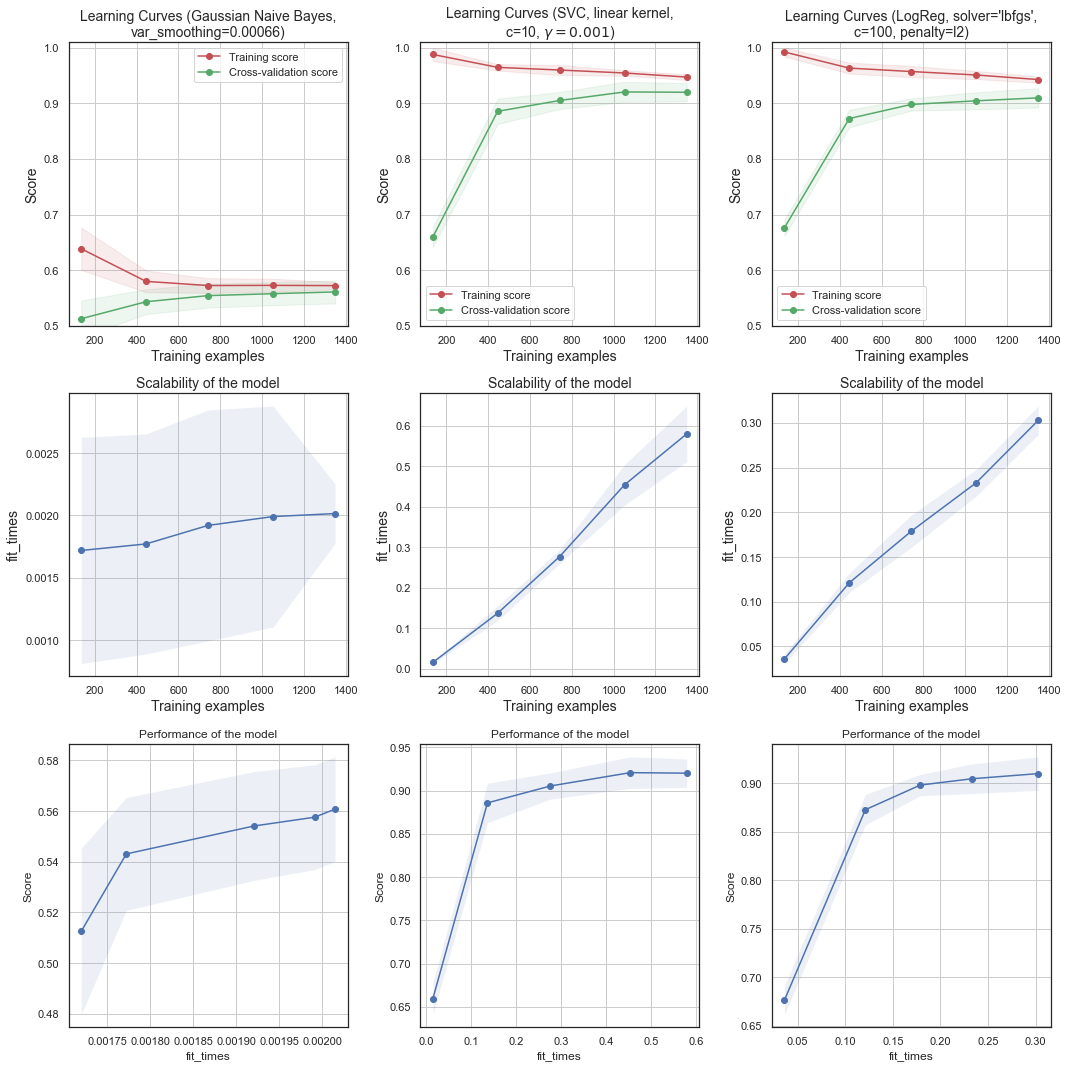

In [150]:
# Plot learning curves
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

title = "Learning Curves (Gaussian Naive Bayes, var_smoothing=0.00066)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB(var_smoothing=0.0006579)
plot_learning_curve(
    estimator, title, X9_train, y9_train, axes=axes[:, 0], ylim=(0.5, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVC, linear kernel, c=10, $\gamma=0.001$)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
svc = SVC(C=10, kernel='linear', gamma=0.001, coef0=0.0, shrinking=True, probability=True, 
                      tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, 
                      decision_function_shape='ovr', break_ties=False, random_state=1)
estimator = svc 
plot_learning_curve(
    estimator, title, X9_train_scaled, y9_train, axes=axes[:, 1], ylim=(0.5, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (LogReg, solver='lbfgs', c=100, penalty=l2)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=100, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimator = logreg 
plot_learning_curve(
    estimator, title, X9_train_scaled, y9_train, 
    axes=axes[:, 2], ylim=(0.5, 1.01), cv=cv, n_jobs=4
)
fig.tight_layout()
#fig.savefig("learning_curves_2.jpg")
plt.show()

### HOW SPARCE CAN WE MAKE THE MODEL WITHOUT USING PREDICTIVE VALUE? 

### Used recursive feature elimination to determine what are the top contributing features

In [151]:
# Recursive feature elimination
from sklearn.feature_selection import RFE
rfe = RFE(estimator=svc,n_features_to_select=12)
rfe.fit_transform(X9_train_scaled,y9_train)

# Print Score 
# 'Score(X,y)' reduces X to the selected features and returns the score of the underlying estimator.
# The top 4 features are different to those found by the SelectKBest method 
                      # - 'Age', 'BMI' and 'Insulin' are not selected.

print("Score: ", rfe.score(X9_train_scaled,y9_train))

# Find Top 12 Features
print("Top 12 features: ", rfe.get_feature_names_out())

Score:  0.9295023696682464
Top 12 features:  ['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x8' 'x12' 'x13' 'x17' 'x21']


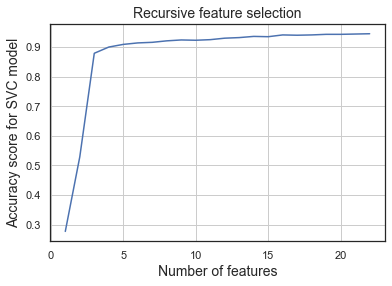

In [152]:
scores = [0.277,0.529,0.879,0.900,0.909,0.914,0.916,0.921,0.924,0.923,0.925,0.930,0.932,
        0.936,0.935,0.941,0.940,0.941,0.943,0.943,0.944,0.945]
xaxis = np.arange(1,23,1)
plt.plot(xaxis,scores)
plt.xlabel("Number of features",fontsize=14)
plt.ylabel("Accuracy score for SVC model",fontsize=14)
plt.title("Recursive feature selection",fontsize=14)
plt.grid(visible=True, which='major', axis='both')
#plt.savefig("recursive_feature_selection.jpg")
plt.show()

### HOW ACCURATELY CAN WE PREDICT OBESITY WITHOUT THE BMI, WEIGHT & CH2O_adj VARIABLES?

### I suspect that the CH2O_adj feature is still capturing 'weight' as a predictor of obesity class, as it was calculated from weight and correlates well with weight. I want to see how accurately we can predict obesity from just behaviour, without any body metrics at all. 

In [156]:
# Dropped BMI, Weight, CH2O_adj, Height, and NObeyesdad from the dataset
X10 = obesity_dum.drop(["Height","Weight","BMI","CH2O_adj","NObeyesdad"],axis=1)
y10 = obesity_dum["NObeyesdad"]

In [159]:
# What are the best predictors now?
corr = X10.corrwith(obesity_dum.NObeyesdad, axis=0, drop=False, method='pearson').sort_values(ascending=False)
corr_short = corr[(corr != 1.0)&((corr > 0.2)|(corr < -0.2))]
corr_short.sort_values(ascending=False)
corr_short

family_history_with_overweight    0.505148
CAEC_Sometimes                    0.453188
Age                               0.282913
FAVC                              0.247793
FCVC                              0.227759
CALC_Sometimes                    0.214067
CAEC_Frequently                  -0.418948
dtype: float64

Top 5 predictors are family history, eating between meals (sometimes), eating between meals (frequently - but negatively correlated with obesity!!), age, and frequent consumption of high calorie food.

### MODEL 12 - Support Vector Classification (SVC) without any body metrics

In [160]:
# Split and scale data
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size = 0.2, random_state = 1)

scaler = StandardScaler()
X10_train_scaled = scaler.fit_transform(X10_train)
X10_test_scaled = scaler.transform(X10_test)

In [161]:
# Find the optimal hyperparameters for the model using Gridsearch()
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

svc = SVC(coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, 
          verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=1)
gs = GridSearchCV(estimator=svc, param_grid=svc_params)
gs.fit(X10_train_scaled, y10_train)
sorted(gs.cv_results_.keys())

print("Best estimator:", '\t', gs.best_estimator_)
print("Best score:", '\t', '\t', gs.best_score_)
print("Best parameters:", '\t', gs.best_params_)
print("Best scorer:", '\t', '\t', gs.scorer_)
print("No. CV splits:", '\t', '\t', gs.n_splits_)
print("Refit time:", '\t', '\t', gs.refit_time_)
print("Multimetric:", '\t', '\t', gs.multimetric_)
print("Classes:", '\t', '\t', gs.classes_)
print("No. of features:", '\t', gs.n_features_in_)

Best estimator: 	 SVC(C=100, gamma=0.001, random_state=1)
Best score: 	 	 0.6759433216863029
Best parameters: 	 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best scorer: 	 	 <function _passthrough_scorer at 0x7ffdda24ae50>
No. CV splits: 	 	 5
Refit time: 	 	 0.13499784469604492
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 21


In [162]:
# Fitting SVC model to data (without the BMI, Weight, Height and CH2O_adj features)
# The best kernal has changed to 'rbf'

svc = SVC(C=100, kernel='rbf', gamma=0.001, coef0=0.0, shrinking=True, probability=False, 
          tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, 
          decision_function_shape='ovr', break_ties=False, random_state=1)

svc.fit(X10_train_scaled, y10_train, sample_weight=None)

score = svc.score(X10_train_scaled, y10_train, sample_weight=None)
print("Accuracy score (training data, all features): ", score)

Accuracy score (training data, all features):  0.7221563981042654


In [163]:
# Cross-validation (without the BMI, Weight, Height and CH2O_adj features)
# Mean cross_validation score is lower than the accuracy score obtained from fitting the full training dataset

scores = cross_val_score(svc, X10_train_scaled, y10_train, cv=10)
print("CV scores: ", scores)
print("Mean CV score: ", np.mean(scores))

CV scores:  [0.71005917 0.70414201 0.72189349 0.70414201 0.64497041 0.63313609
 0.65680473 0.67455621 0.66666667 0.70833333]
Mean CV score:  0.6824704142011834


In [164]:
# Testing how well the test data does on the SVC model (without the BMI, Weight, Height and CH2O_adj features)
# Accuracy score is lower than the accuracy score for the training data; suggests overfitting

score2 = svc.score(X10_test_scaled, y10_test, sample_weight=None)
print("Accuracy score (test data, all features): ", score2)

# predict test class:
y_pred_class = svc.predict(X10_test_scaled)

# predicted test probability:
#preds = svc.predict_proba(X10_test_scaled)[:,1]

Accuracy score (test data, all features):  0.6761229314420804


In [165]:
# Confusion matrix SVC model (without the BMI, Weight, Height and CH2O_adj features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y10_test, y10_pred_class)
df_svc = pd.DataFrame(cm, index=index, columns=columns)
df_svc

predicted_underweight  predicted_normal  \
is_underweight                       58                 3   
is_normal                             4                32   
is_overweight_I                       0                 6   
is_overweight_II                      0                 0   
is_obese_I                            0                 0   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         0                        0   
is_normal                              7                        1   
is_overweight_I                       49                        6   
is_overweight_II                       4                       52   
is_obese_I                             0                        9   
is_obese_II                            0                        1   
is_obese_III                           0                        0   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    0                   0                    0  
is_normal                         0                   0                    1  
is_overweight_I                   0                   0                    0  
is_overweight_II                  4                   0                    0  
is_obese_I                       65                   3                    2  
is_obese_II                       1                  52                    0  
is_obese_III                      0                   2                   61

In [169]:
# Classification report SVC model (without the BMI, Weight, Height and CH2O_adj features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y10_test, y_pred_class, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.76      0.87      0.81        61
       is_normal       0.49      0.51      0.50        45
 is_overweight_I       0.67      0.51      0.58        61
is_overweight_II       0.63      0.43      0.51        60
      is_obese_I       0.52      0.54      0.53        79
     is_obese_II       0.67      0.91      0.77        54
    is_obese_III       0.95      0.97      0.96        63

        accuracy                           0.68       423
       macro avg       0.67      0.68      0.67       423
    weighted avg       0.67      0.68      0.67       423



### MODEL 13 - Logistic Regression Model without any body metrics

In [170]:
# Applied 'Gridsearch' to find the best parameters for the Logistic Regression model (without the BMI, Weight, Height and CH2O_adj features)

lr_params = {
    'penalty': ['l2'],    # 'penalty': ['l1','l2'],
    'C': [1, 10, 100]}

y10_train = y10_train.ravel()
logreg = LogisticRegression(dual=False, tol=0.0001, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
clf = GridSearchCV(estimator=logreg, param_grid=lr_params)
clf.fit(X10_train_scaled, y10_train)
sorted(clf.cv_results_.keys())

# Print results of gridsearch on Logistic Regression model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Best estimator: 	 LogisticRegression(C=100, max_iter=10000, random_state=1)
Best score: 	 	 0.6338928590241075
Best parameters: 	 {'C': 100, 'penalty': 'l2'}
Best scorer: 	 	 <function _passthrough_scorer at 0x7ffdda24ae50>
No. CV splits: 	 	 5
Refit time: 	 	 0.23683381080627441
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 21


In [171]:
# Fitted Logistic Regression model to data (without the BMI, Weight, Height and CH2O_adj features)

logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=100, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

logreg.fit(X10_train_scaled, y10_train, sample_weight=None)
logreg.coef_
print("Intercept: ", logreg.intercept_[0])

score20 = logreg.score(X10_train_scaled, y10_train, sample_weight=None)
print("Accuracy score (train data): ", score20)

# Cross-validation
# Mean cross_validation score is lower than the accuracy score obtained from fitting the full training dataset

scores21 = cross_val_score(logreg, X10_train_scaled, y10_train, cv=10)
print("CV scores: ", scores21)
print("Mean CV score: ", np.mean(scores21))

# Testing how well the test data does on the model
# Accuracy score is lower than the accuracy score for the training data, which suggests a bit of overfitting

score22 = logreg.score(X10_test_scaled, y10_test, sample_weight=None)
print("Accuracy score (test data): ", score22)

# predict test class:
y13_pred_class = logreg.predict(X10_test_scaled)

# predicted test probability:
preds13 = logreg.predict_proba(X10_test_scaled)[:,1]

Intercept:  2.841980370202722
Accuracy score (train data):  0.6534360189573459
CV scores:  [0.67455621 0.62130178 0.63905325 0.62721893 0.60946746 0.63313609
 0.59171598 0.62721893 0.63690476 0.66071429]
Mean CV score:  0.6321287686672302
Accuracy score (test data):  0.5910165484633569


In [172]:
# Confusion matrix LogReg Model (without the BMI, Weight, Height and CH2O_adj features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y10_test, y13_pred_class)
df_logreg = pd.DataFrame(cm, index=index, columns=columns)
df_logreg

predicted_underweight  predicted_normal  \
is_underweight                       45                 8   
is_normal                            11                20   
is_overweight_I                       2                 9   
is_overweight_II                      5                 1   
is_obese_I                            4                 1   
is_obese_II                           0                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         4                        1   
is_normal                              5                        4   
is_overweight_I                       27                        6   
is_overweight_II                       6                       11   
is_obese_I                             6                        8   
is_obese_II                            0                        0   
is_obese_III                           0                        1   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                    2                   1                    0  
is_normal                         4                   0                    1  
is_overweight_I                  10                   7                    0  
is_overweight_II                 24                  13                    0  
is_obese_I                       42                  17                    1  
is_obese_II                      10                  44                    0  
is_obese_III                      1                   0                   61

In [173]:
# Classification report LogReg Model (without the BMI, Weight, Height and CH2O_adj features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y10_test, y13_pred_class, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.67      0.74      0.70        61
       is_normal       0.51      0.44      0.48        45
 is_overweight_I       0.56      0.44      0.50        61
is_overweight_II       0.35      0.18      0.24        60
      is_obese_I       0.45      0.53      0.49        79
     is_obese_II       0.54      0.81      0.65        54
    is_obese_III       0.97      0.97      0.97        63

        accuracy                           0.59       423
       macro avg       0.58      0.59      0.57       423
    weighted avg       0.58      0.59      0.58       423



### MODEL 14 - Gaussian NB Model without any body metrics

In [175]:
# Applied 'Gridsearch' to find the best parameters for the Gaussian NB model without the BMI, Weight, Height and CH2O_adj features

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gnb = GaussianNB() 
clf = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
clf.fit(X10_train, y10_train)

# Print results of gridsearch on SVC model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best estimator: 	 GaussianNB(var_smoothing=0.0005336699231206307)
Best score: 	 	 0.5681177796562412
Best parameters: 	 {'var_smoothing': 0.0005336699231206307}
Best scorer: 	 	 <function _passthrough_scorer at 0x7ffdda24ae50>
No. CV splits: 	 	 10
Refit time: 	 	 0.007870912551879883
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 21


In [178]:
# Fitting the Gaussian NB model to the training data

# scaler = StandardScaler() # Model performed better with unscaled data

gnb = GaussianNB(var_smoothing=0.0005336699231206307)

y14_pred_bayes = gnb.fit(X10_train, y10_train).predict(X10_train)
print("Number of mislabeled points out of a total %d points (training data) : %d" % (X10_train.shape[0], (y10_train != y14_pred_bayes).sum()))
print("Accuracy (training data): ", (((X10_train.shape[0]) - ((y10_train != y14_pred_bayes).sum())) / (X10_train.shape[0])))

# Cross-validation
# Mean cross_validation score is the same as the accuracy score obtained from fitting the full training dataset

scores30 = cross_val_score(gnb, X10_train, y10_train, cv=10)
print("CV scores: ", scores30)
print("Mean CV score: ", np.mean(scores30))

# Testing the model on the test data

y14_pred_bayes_test = gnb.predict(X10_test)
print("Number of mislabeled points out of a total %d points (test data) : %d" % (X10_test.shape[0], (y10_test != y14_pred_bayes_test).sum()))
print("Accuracy (test data): ", (((X10_test.shape[0]) - ((y10_test != y14_pred_bayes_test).sum())) / (X10_test.shape[0])))

Number of mislabeled points out of a total 1688 points (training data) : 720
Accuracy (training data):  0.5734597156398105
CV scores:  [0.5739645  0.57988166 0.58579882 0.59763314 0.53846154 0.55621302
 0.55029586 0.57988166 0.54166667 0.57738095]
Mean CV score:  0.5681177796562412
Number of mislabeled points out of a total 423 points (test data) : 191
Accuracy (test data):  0.5484633569739953


In [179]:
# Confusion matrix (Gaussian NB, without the BMI, Weight, Height and CH2O_adj features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y10_test, y14_pred_bayes_test)
df_bayes_14 = pd.DataFrame(cm, index=index, columns=columns)
df_bayes_14

predicted_underweight  predicted_normal  \
is_underweight                       40                 4   
is_normal                            19                12   
is_overweight_I                       2                 5   
is_overweight_II                      4                 2   
is_obese_I                            4                 2   
is_obese_II                           1                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         2                        0   
is_normal                              5                        4   
is_overweight_I                       15                        9   
is_overweight_II                       0                       16   
is_obese_I                             2                        7   
is_obese_II                            0                        0   
is_obese_III                           0                        1   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                   12                   3                    0  
is_normal                         4                   1                    0  
is_overweight_I                  15                  15                    0  
is_overweight_II                 20                  17                    1  
is_obese_I                       35                  26                    3  
is_obese_II                       1                  52                    0  
is_obese_III                      0                   0                   62

In [181]:
# Classification report (Gaussian NB, without the BMI, Weight, Height and CH2O_adj features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y10_test, y14_pred_bayes_test, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.57      0.66      0.61        61
       is_normal       0.48      0.27      0.34        45
 is_overweight_I       0.62      0.25      0.35        61
is_overweight_II       0.43      0.27      0.33        60
      is_obese_I       0.40      0.44      0.42        79
     is_obese_II       0.46      0.96      0.62        54
    is_obese_III       0.94      0.98      0.96        63

        accuracy                           0.55       423
       macro avg       0.56      0.55      0.52       423
    weighted avg       0.56      0.55      0.52       423



### MODEL 15 - Bernoulli NB Model without any body metrics

In [184]:
# Applied 'Gridsearch' to find the best parameters for the Bernoulli NB model without the BMI, Weight, Height and CH2O_adj features

from sklearn.naive_bayes import BernoulliNB
param_grid_bnb = {
    'alpha': np.logspace(0,-9, num=100)
}
bnb = BernoulliNB(binarize=0.0, fit_prior=True, class_prior=None)
clf = GridSearchCV(estimator=bnb, param_grid=param_grid_bnb, verbose=1, cv=10, n_jobs=-1)
clf.fit(X10_train, y10_train)

# Print results of gridsearch on SVC model

print("Best estimator:", '\t', clf.best_estimator_)
print("Best score:", '\t', '\t', clf.best_score_)
print("Best parameters:", '\t', clf.best_params_)
print("Best scorer:", '\t', '\t', clf.scorer_)
print("No. CV splits:", '\t', '\t', clf.n_splits_)
print("Refit time:", '\t', '\t', clf.refit_time_)
print("Multimetric:", '\t', '\t', clf.multimetric_)
print("Classes:", '\t', '\t', clf.classes_)
print("No. of features:", '\t', clf.n_features_in_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best estimator: 	 BernoulliNB(alpha=0.003511191734215131)
Best score: 	 	 0.5320054945054946
Best parameters: 	 {'alpha': 0.003511191734215131}
Best scorer: 	 	 <function _passthrough_scorer at 0x7ffdda24ae50>
No. CV splits: 	 	 10
Refit time: 	 	 0.010631799697875977
Multimetric: 	 	 False
Classes: 	 	 [1 2 3 4 5 6 7]
No. of features: 	 21


In [185]:
# Fitting the Bernoulli NB model to the training data

# scaler = StandardScaler() # Model performed better with unscaled data

bnb = BernoulliNB(alpha=0.003511191734215131)

y15_pred_bayes = bnb.fit(X10_train, y10_train).predict(X10_train)
print("Number of mislabeled points out of a total %d points (training data) : %d" % (X10_train.shape[0], (y10_train != y15_pred_bayes).sum()))
print("Accuracy (training data): ", (((X10_train.shape[0]) - ((y10_train != y15_pred_bayes).sum())) / (X10_train.shape[0])))

# Cross-validation
# Mean cross_validation score is the same as the accuracy score obtained from fitting the full training dataset

scores40 = cross_val_score(bnb, X10_train, y10_train, cv=10)
print("CV scores: ", scores40)
print("Mean CV score: ", np.mean(scores40))

# Testing the model on the test data

y15_pred_bayes_test = gnb.predict(X10_test)
print("Number of mislabeled points out of a total %d points (test data) : %d" % (X10_test.shape[0], (y10_test != y15_pred_bayes_test).sum()))
print("Accuracy (test data): ", (((X10_test.shape[0]) - ((y10_test != y15_pred_bayes_test).sum())) / (X10_test.shape[0])))

Number of mislabeled points out of a total 1688 points (training data) : 782
Accuracy (training data):  0.5367298578199052
CV scores:  [0.56804734 0.55029586 0.53846154 0.57988166 0.44970414 0.49112426
 0.50887574 0.5443787  0.55952381 0.5297619 ]
Mean CV score:  0.5320054945054946
Number of mislabeled points out of a total 423 points (test data) : 191
Accuracy (test data):  0.5484633569739953


In [186]:
# Confusion matrix (Bernoulli NB, without the BMI, Weight, Height and CH2O_adj features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['predicted_underweight','predicted_normal', 'predicted_overweight_I', 'predicted_overweight_II', 'predicted_obese_I', 'predicted_obese_II', 'predicted_obese_III']
cm = confusion_matrix(y10_test, y15_pred_bayes_test)
df_bayes_15 = pd.DataFrame(cm, index=index, columns=columns)
df_bayes_15

predicted_underweight  predicted_normal  \
is_underweight                       40                 4   
is_normal                            19                12   
is_overweight_I                       2                 5   
is_overweight_II                      4                 2   
is_obese_I                            4                 2   
is_obese_II                           1                 0   
is_obese_III                          0                 0   

                  predicted_overweight_I  predicted_overweight_II  \
is_underweight                         2                        0   
is_normal                              5                        4   
is_overweight_I                       15                        9   
is_overweight_II                       0                       16   
is_obese_I                             2                        7   
is_obese_II                            0                        0   
is_obese_III                           0                        1   

                  predicted_obese_I  predicted_obese_II  predicted_obese_III  
is_underweight                   12                   3                    0  
is_normal                         4                   1                    0  
is_overweight_I                  15                  15                    0  
is_overweight_II                 20                  17                    1  
is_obese_I                       35                  26                    3  
is_obese_II                       1                  52                    0  
is_obese_III                      0                   0                   62

In [187]:
# Classification report (Bernoulli NB, without the BMI, Weight, Height and CH2O_adj features)

index=['is_underweight', 'is_normal', 'is_overweight_I', 'is_overweight_II', 'is_obese_I', 'is_obese_II', 'is_obese_III']
columns=['precision', 'recall', 'f1-score', 'support']
print(classification_report(y10_test, y15_pred_bayes_test, target_names=index))

                  precision    recall  f1-score   support

  is_underweight       0.57      0.66      0.61        61
       is_normal       0.48      0.27      0.34        45
 is_overweight_I       0.62      0.25      0.35        61
is_overweight_II       0.43      0.27      0.33        60
      is_obese_I       0.40      0.44      0.42        79
     is_obese_II       0.46      0.96      0.62        54
    is_obese_III       0.94      0.98      0.96        63

        accuracy                           0.55       423
       macro avg       0.56      0.55      0.52       423
    weighted avg       0.56      0.55      0.52       423



### Conclusions 

### Learning Curves for SVC, Logistic Regression & Bayes Models - without BMI, Weight, CH2O_adj & Height Features

The SVC model is the best performer, and the training and cross-validation scores are converging nicely. 
The LogReg model may continue to increase in performance with more data.

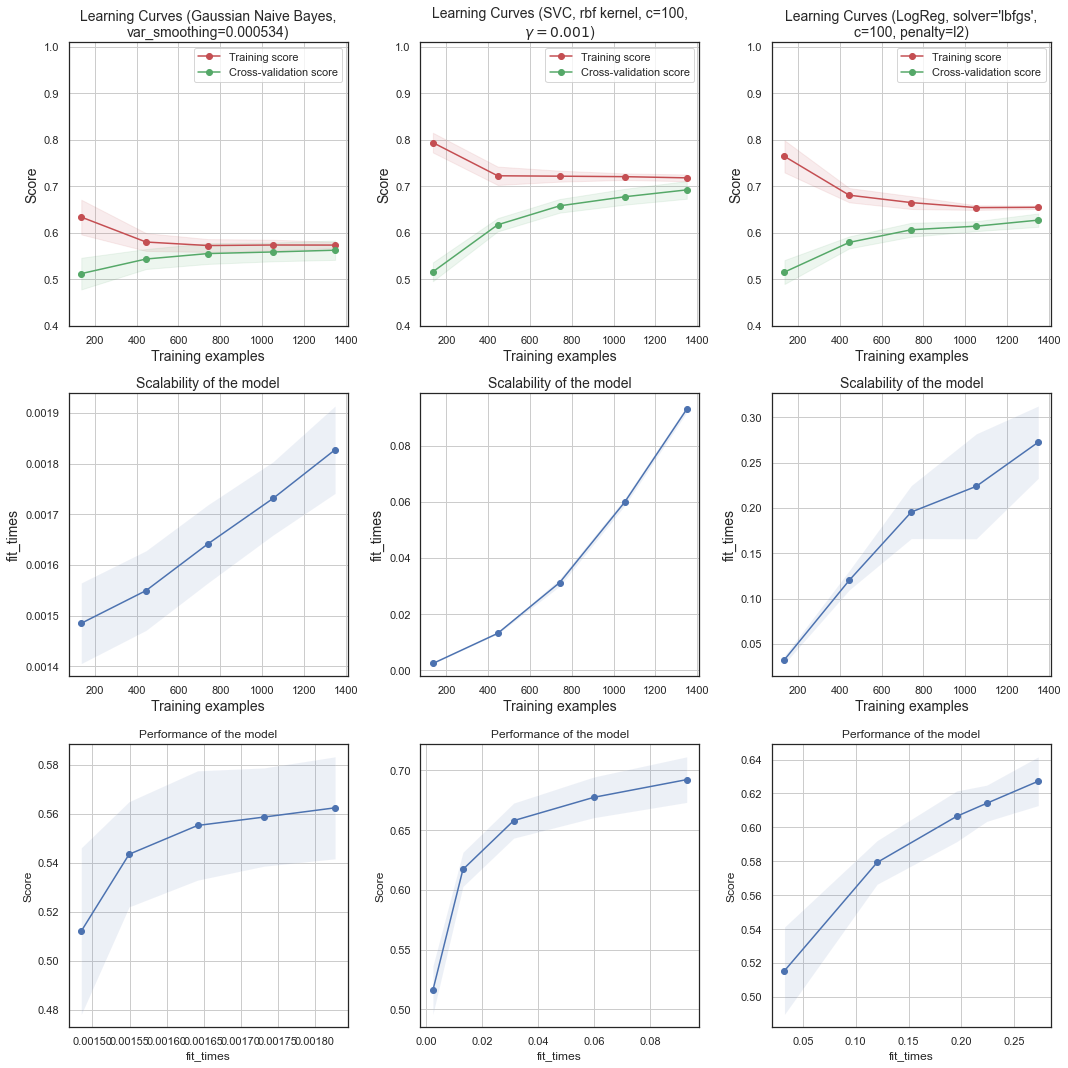

In [183]:
# Plot learning curves
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

title = "Learning Curves (Gaussian Naive Bayes, var_smoothing=0.000534)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB(var_smoothing=0.000534)
plot_learning_curve(
    estimator, title, X10_train, y10_train, axes=axes[:, 0], ylim=(0.4, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVC, rbf kernel, c=100, $\gamma=0.001$)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
svc = SVC(C=100, kernel='rbf', gamma=0.001, coef0=0.0, shrinking=True, probability=False, 
                      tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, 
                      decision_function_shape='ovr', break_ties=False, random_state=1)
estimator = svc 
plot_learning_curve(
    estimator, title, X10_train_scaled, y10_train, axes=axes[:, 1], ylim=(0.4, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (LogReg, solver='lbfgs', c=100, penalty=l2)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=100, fit_intercept=True, intercept_scaling=1, 
                            class_weight=None, random_state=1, solver='lbfgs', max_iter=10000, 
                            multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
estimator = logreg 
plot_learning_curve(
    estimator, title, X10_train_scaled, y10_train, 
    axes=axes[:, 2], ylim=(0.4, 1.01), cv=cv, n_jobs=4
)
fig.tight_layout()
#fig.savefig("learning_curves_3.jpg")
plt.show()

## NEXT STEP

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

### NOTES

- Do EDA first before data gets ugly with get_dummies replacements etc.
- Just use .replace() to convert the binary nominal columns (male/female, yes/no) to 0/1
- Use pandas get_dummies on the categorical but non-binary columns (i.e. the no>sometimes>... and the MTRANS columns)
- For analysis, remove one column for each of the 'dummy' columns to avoid co-linearity. 
- Then do test-train split
- Then standard_scaler (both train and test data gets scaled, but do .fit_transform() on training data only, and just .transform() on test data. 

### References: